<a href="https://colab.research.google.com/github/alessandra-barbosa/cardio_catch_disease/blob/main/AB_cardio_catch_diseases_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Cardio Image](https://img.freepik.com/free-photo/human-heart-design_1048-1855.jpg?size=626&ext=jpg&ga=GA1.1.110088987.1677679311&semt=ais)
<h1>Cardio Catch Diseases </h1>

## 0.0 - Planning and Business Knowledge

<h4>0.1. Business Problem.</h4>
<p>Cardio Catch Diseases is a company specialized in detecting heart disease in the early stages. Its business model lies in offering an early diagnosis of cardiovascular disease for a certain price.

<h4>0.2. Objective</h4>
    <li>Growth diagnostic precision and make stable.</li>


<h4>0.3. Justification</h4>
    <li>Currently, it's a manual diagnostic by humans.</li>
    <li>Low Precision, between 55% and 65%.</li>
    <li>Hight cost around one thousand (1.000,00) Reals with operators and machines costing.</li>
    <li>The revenue is variable accordingly precision from diagnostics, 500 each 5% above than 50% precision.</li>
    
<h4>0.4. Solution Proposal</h4>
    <lu>
        <li>Collect data from <a href="https://www.kaggle.com/sulianova/cardiovascular-disease-dataset">Kaggle</a></li>
        <li>Build a binary classification with <b>Machine Learning</b> or <b>statistics models</b> solution to diseases prediction.</li>
    </lu>
    
<h4>0.5 Report</h4>
    <lu>
        <li>What the precision accuracy from the solution?.</li>
        <li>How much profit you will get because of that solution?</li>
        <li>how reliable is the solution?</li>
    </lu>

<h4>0.6 Premises</h4>
    <lu>
        <li>Drop inconsistent data from low pressure .</li>
        <li>Drop inconsistent data from high pressure</li>
        <li>Drop inconsistent data from height</li>
        <li>Drop inconsistent data from weight</li>
    </lu>

## 1.0 - Imports

### 1.1 - Libraries

In [190]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
from random import sample as sp
from pandas_profiling      import ProfileReport #conda install -c conda-forge ydata-profiling

## Database 
from sqlalchemy import create_engine
import sqlite3

## Data Transformation
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder

## Visualization
import seaborn as sns
from seaborn import pairplot
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from scipy.stats import pointbiserialr

## Machine Learning, selection and split
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition          import PCA
from sklearn.metrics import accuracy_score, recall_score, precision_score,f1_score
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score,RandomizedSearchCV,GridSearchCV
import pickle

## Configurations
from IPython.display import Image
from IPython.display import HTML
import warnings



### 1.2 - Funcions

In [191]:
# Calculating Scores to classification 
def metrics_score(y_valid, y_hat, mdl_name):
    '''
        y_hat:    is the prediction array
        y_valid:  is the true targe array or series
        mdl_name: is the name of machine learning model
        
        Accuracy formula  -->   accuracy   = np.mean(y_hat == y_valid)
        Precision formula -->   precision  = positive_true/(positive_true+positive_false)      
        Recall formula    -->   recall     = positive_true/(positive_true+negative_false)
        
        Return -->> mdl_name, accuracy, precision, recall
        
    '''
    accuracy = accuracy_score(y_valid, y_hat)
    precision = precision_score(y_valid, y_hat)
    recall = recall_score(y_valid, y_hat)
    F1_score = f1_score(y_valid, y_hat)

    
    return pd.DataFrame([[mdl_name, accuracy, precision, recall,F1_score]], 
                        columns=['mdl_name', 'accuracy', 'precision', 'recall', 'F1_score'
                                 ])
    


# Jupyter configuring to better experience
def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  


def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# To hide warning messages
warnings.filterwarnings('ignore')


Populating the interactive namespace from numpy and matplotlib


### 1.3 - Data Collect - CSV

In [192]:
# Loading dataset
# from google import colab as cl
# file_upload=cl.files.upload()
df = pd.read_csv('/content/cardio_train.csv', sep=';')
# df = pd.read_csv(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\datasets\cardio_train.csv', sep=';')

### 1.4 - Test splitvo

In [193]:
df, df_test = train_test_split(df)
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
21043,30058,20487,2,175,80.0,130,90,1,3,0,0,1,1
49074,70050,18745,1,160,94.0,170,90,1,1,0,0,1,1
6789,9679,21974,1,170,80.0,120,80,1,1,0,0,1,1
25187,35961,19595,2,178,74.0,120,80,1,1,0,0,0,0
52373,74702,21351,2,159,56.0,130,70,1,3,0,0,1,0


### 1.5 - Creating Datawerehouse

##### 1.5.1 - Rename Columns

In [194]:
# Old columns
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

In [195]:
# Rewriting columns names and replace then
new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
       'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']
df.columns = new_col
df.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'hight_pressure',
       'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active',
       'cardio'],
      dtype='object')

##### 1.5.2 - Database

In [196]:
# # creating database
# path_local="C:/Users/Utente77/repos/cardio_catch_disease_PA001/"
# engine_db = create_engine(f"sqlite:////{path_local}/ccd.db", echo=False)
# conn = sqlite3.Connection('cardio_disease.db')
# cursor = conn.cursor()

# # create table
# query = '''CREATE TABLE IF NOT EXISTS patients(
#                                 id INTEGER,
#                                 age INTEGER,
#                                 gender INTEGER,
#                                 height INTEGER,
#                                 weight INTEGER,
#                                 hight_pressure INTEGER,
#                                 low_pressure INTEGER,
#                                 cholesterol INTEGER,
#                                 glucose INTEGER,
#                                 smoker INTEGER,
#                                 alcohol INTEGER,
#                                 active INTEGER,
#                                 cardio INTEGER
#                                 )'''

# cursor.execute(query)
# #engine = engine_db()
# df.to_sql('patients', con=conn, if_exists='append', index=False)



#### 1.5.3 - Data Collect from Database

In [197]:
# # Selecting data
# query="""
#     SELECT *
#     FROM patients;

# """
# df=pd.read_sql_query(query,conn)


## 2.0 - Descriptive Analysis

### 2.1 - Dimensions

In [198]:
# Printing the data dimensions, how much rows and columns
print(f'{df.shape[0]} linhas.')
print(f'{df.shape[1]} colunas.')

52500 linhas.
13 colunas.


### 2.2 - Datatype and NaN fillout

In [199]:
# Columns Datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52500 entries, 21043 to 30843
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              52500 non-null  int64  
 1   age             52500 non-null  int64  
 2   gender          52500 non-null  int64  
 3   height          52500 non-null  int64  
 4   weight          52500 non-null  float64
 5   hight_pressure  52500 non-null  int64  
 6   low_pressure    52500 non-null  int64  
 7   cholesterol     52500 non-null  int64  
 8   glucose         52500 non-null  int64  
 9   smoker          52500 non-null  int64  
 10  alcohol         52500 non-null  int64  
 11  active          52500 non-null  int64  
 12  cardio          52500 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 5.6 MB


In [200]:
aux=df.isna().sum().sort_values(ascending=False)
aux1=df.isna().sum().sort_values(ascending=False)/df.shape[0]*100

na=pd.concat([aux,aux1],axis=1)
na.columns=['NaN', 'NaN %']
na

,NaN,NaN %
id,0,0.0
age,0,0.0
gender,0,0.0
height,0,0.0
weight,0,0.0
hight_pressure,0,0.0
low_pressure,0,0.0
cholesterol,0,0.0
glucose,0,0.0
smoker,0,0.0


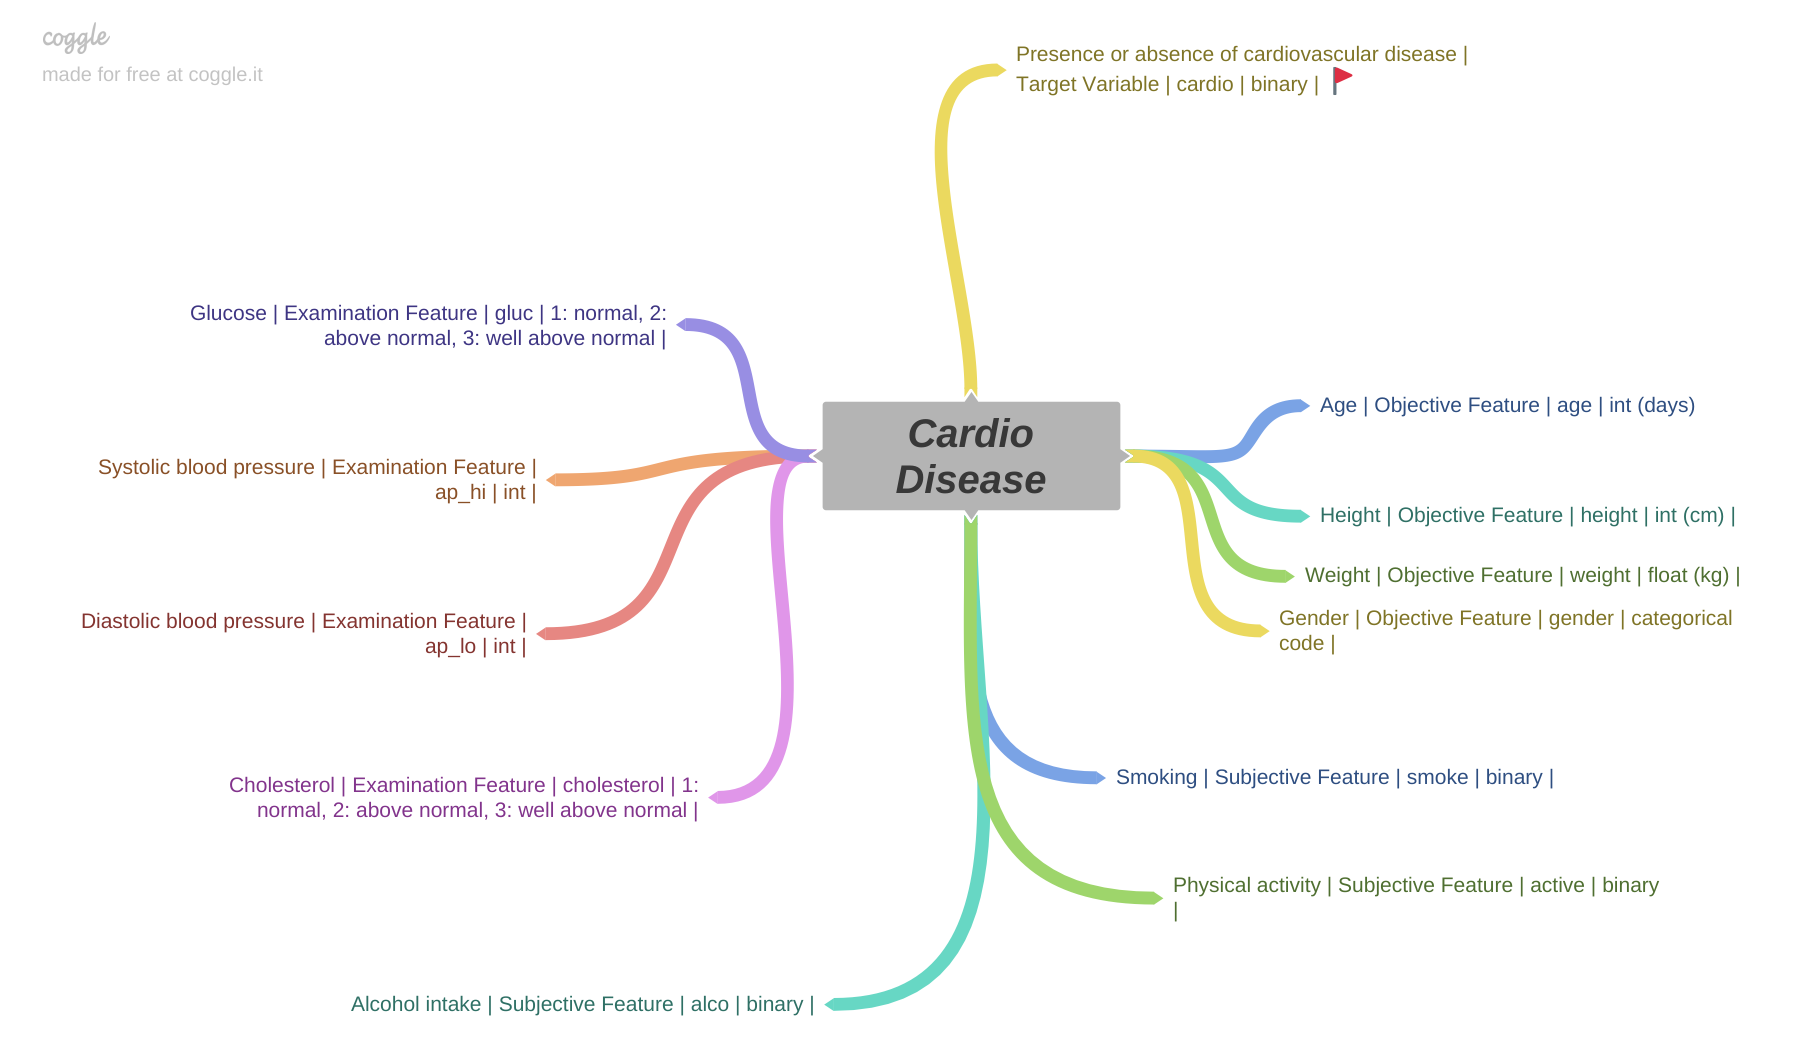

In [201]:
Image('/content/Cardio_Disease.png')
#Image(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\img\Cardio_Disease.png')

### 2.3 - Data Description

In [202]:
# profile=ProfileReport(df, title="Pandas Profiling Report")
# profile.to_file(r"C:\Users\Utente77\repos\cardio_catch_disease_PA001\img\report.html")
# profile

In [203]:
# Descriptive statistics 

describe = df.describe().T.drop('id', axis=0)
describe['range'] = describe['max'] - describe['min']
describe['median'] = df.apply( np.median )
describe['kurtosis'] = df.apply( kurtosis )
describe['skew'] = df.apply( skew )
describe

,count,mean,std,min,25%,50%,75%,max,range,median,kurtosis,skew
age,52500.0,19465.176533,2466.355269,10878.0,17651.0,19704.0,21319.0,23713.0,12835.0,19704.0,-0.826953,-0.303290
gender,52500.0,1.348190,0.476401,1.0,1.0,1.0,2.0,2.0,1.0,1.0,-1.593818,0.637324
height,52500.0,164.360095,8.228912,55.0,159.0,165.0,170.0,250.0,195.0,165.0,8.169573,-0.644164
weight,52500.0,74.171418,14.369995,10.0,65.0,72.0,82.0,200.0,190.0,72.0,2.445532,0.985329
hight_pressure,52500.0,128.264667,128.962409,-120.0,120.0,120.0,140.0,14020.0,14140.0,120.0,9889.855244,97.254592
low_pressure,52500.0,96.644800,188.814915,-70.0,80.0,80.0,90.0,10000.0,10070.0,80.0,1373.997600,31.684940
cholesterol,52500.0,1.367200,0.680386,1.0,1.0,1.0,2.0,3.0,2.0,1.0,0.989262,1.585592
glucose,52500.0,1.226438,0.572487,1.0,1.0,1.0,1.0,3.0,2.0,1.0,4.294252,2.397936
smoker,52500.0,0.088476,0.283989,0.0,0.0,0.0,0.0,1.0,1.0,0.0,6.399540,2.898196
alcohol,52500.0,0.053010,0.224055,0.0,0.0,0.0,0.0,1.0,1.0,0.0,13.920512,3.990052


### <H3>***Problematics*** </H3>
- age in days
- hight_pressure min above 0
- low_pressure min above 



## 3.0 - Feature Engineering

In [204]:
df1=df.copy()

In [205]:
# age - change days to year old
df1['age'] = (df1['age'] / 365).astype('int')

# height - change centimeters to meters
df1['height'] = (df1['height'] / 100)

<h1>BMI Levels</h1>

![Cardio Image](https://www.builtlean.com/wp-content/uploads/2013/06/Bmi-chart-1.jpg)


In [206]:
# BMI calculus and slices in four levels
df1['bmi'] = (df1['weight']/(df1['height'] * df1['height']))
df1['bmi_level'] = df1['bmi'].apply(lambda x: 
                                              0 if x <= 18.5 else
                                              1      if x >  18.5 and x <= 24.9 else
                                              2  if x >= 25.0 and x <= 29.9 else
                                              3)

<h1>Diastolic and systolic blood pressure</h1>

![Cardio Image](https://www.bloomsburysurgery.nhs.uk/media/content/images/bp-range-chart.jpg)


In [207]:
# Hypertension and Hipotension binary
df1['hypertension'] = df1.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
df1['hypotension'] = df1.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)

In [208]:
# A difference between systolic and diastolic arterial pressure, 

df1['difference'] = df1['hight_pressure'] - df1['low_pressure'] # A difference between systolic and diastolic arterial pressure
df1['convergent'] = df1['difference'].apply(lambda x: 1 if x <= 30 else 0) # lesser than 30mmhg called convergent 
df1['divergent'] = df1['difference'].apply(lambda x: 1 if x >= 60 else 0)# and upper than 60mmhg called divergent 

In [209]:
# Slicing ages with three ranges
df1['age_range'] = df1['age'].apply(lambda x: 1    if x <= 50 
                                                   else 2   if x >= 51 and x <= 59 
                                                   else 3 if x >= 60 
                                                   else x)

In [210]:
df1['weight_range'] = df1['weight'].apply(
    lambda x:   0.50 if x <= 50  else
                0.75 if x >= 51  and x <= 75 else
                1.00 if x >= 76  and x <= 100 else
                1.25 if x >= 101 and x <= 125 else
                1.50 if x >= 126 and x <= 150 else
                1.75 if x >= 151 and x <= 175 else 2.00)

In [211]:
# Descriptive statistics after feature engineer 

describe = df1.describe().T.drop('id', axis=0)
describe['range'] = describe['max'] - describe['min']
describe['median'] = df1.apply( np.median )
describe['kurtosis'] = df1.apply( kurtosis )
describe['skew'] = df1.apply( skew )
describe

,count,mean,std,min,25%,50%,75%,max,range,median,kurtosis,skew
age,52500.0,52.831352,6.764719,29.000000,48.000000,53.000000,58.000000,64.000000,35.000000,53.000000,-0.822277,-0.302329
gender,52500.0,1.348190,0.476401,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,-1.593818,0.637324
height,52500.0,1.643601,0.082289,0.550000,1.590000,1.650000,1.700000,2.500000,1.950000,1.650000,8.169573,-0.644164
weight,52500.0,74.171418,14.369995,10.000000,65.000000,72.000000,82.000000,200.000000,190.000000,72.000000,2.445532,0.985329
hight_pressure,52500.0,128.264667,128.962409,-120.000000,120.000000,120.000000,140.000000,14020.000000,14140.000000,120.000000,9889.855244,97.254592
low_pressure,52500.0,96.644800,188.814915,-70.000000,80.000000,80.000000,90.000000,10000.000000,10070.000000,80.000000,1373.997600,31.684940
cholesterol,52500.0,1.367200,0.680386,1.000000,1.000000,1.000000,2.000000,3.000000,2.000000,1.000000,0.989262,1.585592
glucose,52500.0,1.226438,0.572487,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.000000,4.294252,2.397936
smoker,52500.0,0.088476,0.283989,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,6.399540,2.898196
alcohol,52500.0,0.053010,0.224055,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,13.920512,3.990052


## 4.0 - Data Filtering

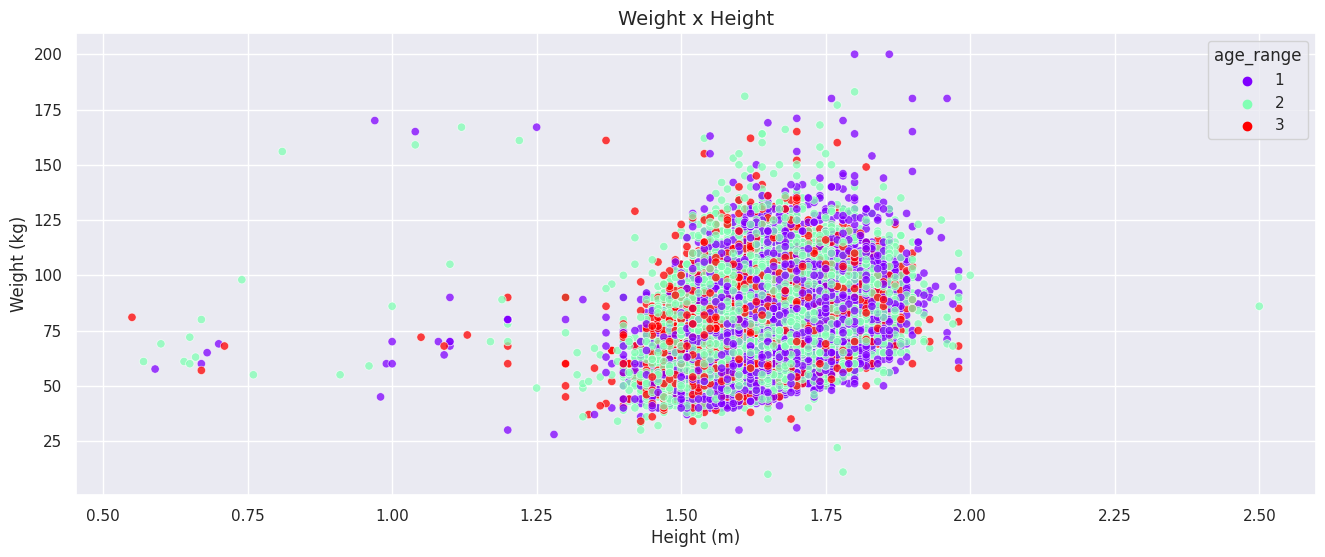

In [212]:
# sets plot size
plt.figure(figsize=(16,6))
# plots scatterplot
plt.subplot(1,3,1)
sns.scatterplot(x='height', y='weight', data=df1, hue='age_range', palette='rainbow', alpha=0.75)
plt.xlabel("Height (m)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Height", fontsize=14)

plt.subplot(1,3,2)
plt.title('Height')
sns.boxplot(df1['height']);

plt.subplot(1,3,3)
plt.title('Weight')
sns.boxplot(df1['weight']);

# displays the plot
plt.show()

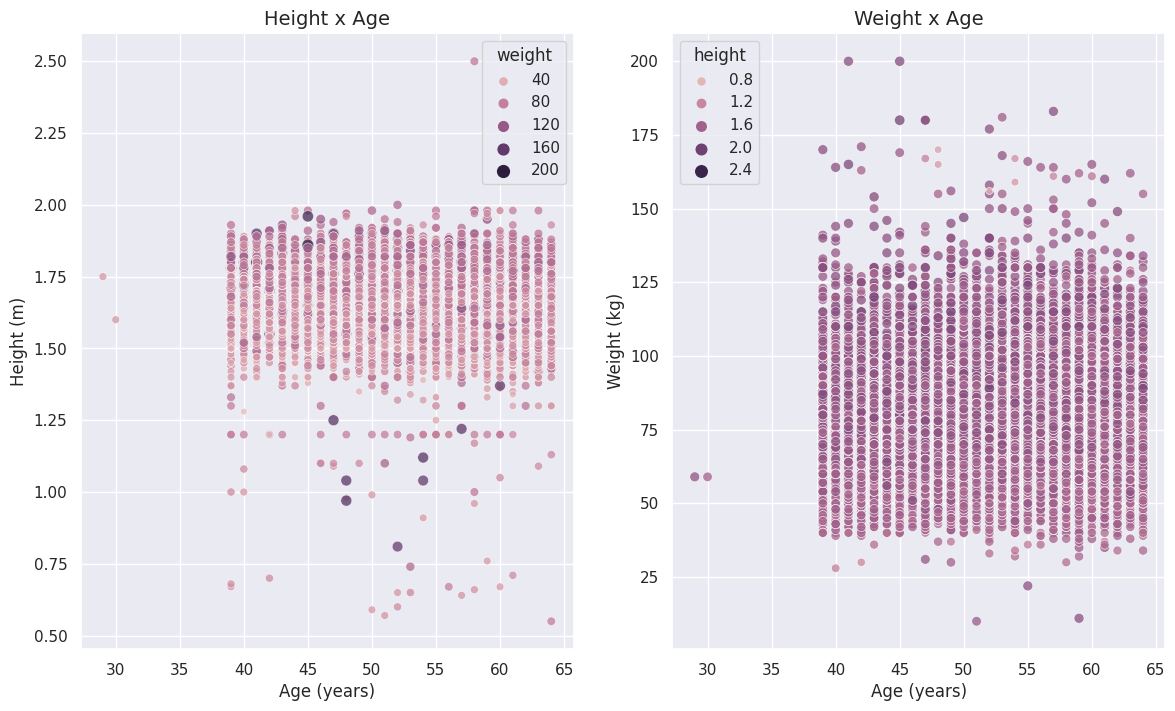

In [213]:
# sets plot size
plt.figure(figsize=(14,8))

# plots scatterplot
plt.subplot(1,2,1)
sns.scatterplot(x='age', y='height', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Height (m)")
plt.title("Height x Age", fontsize=14)

# plots scatterplot
plt.subplot(1,2,2)
sns.scatterplot(x='age', y='weight', data=df1, hue='height', size='height', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Weight (kg)")
plt.title("Weight x Age", fontsize=14)

# displays the plot
plt.show()

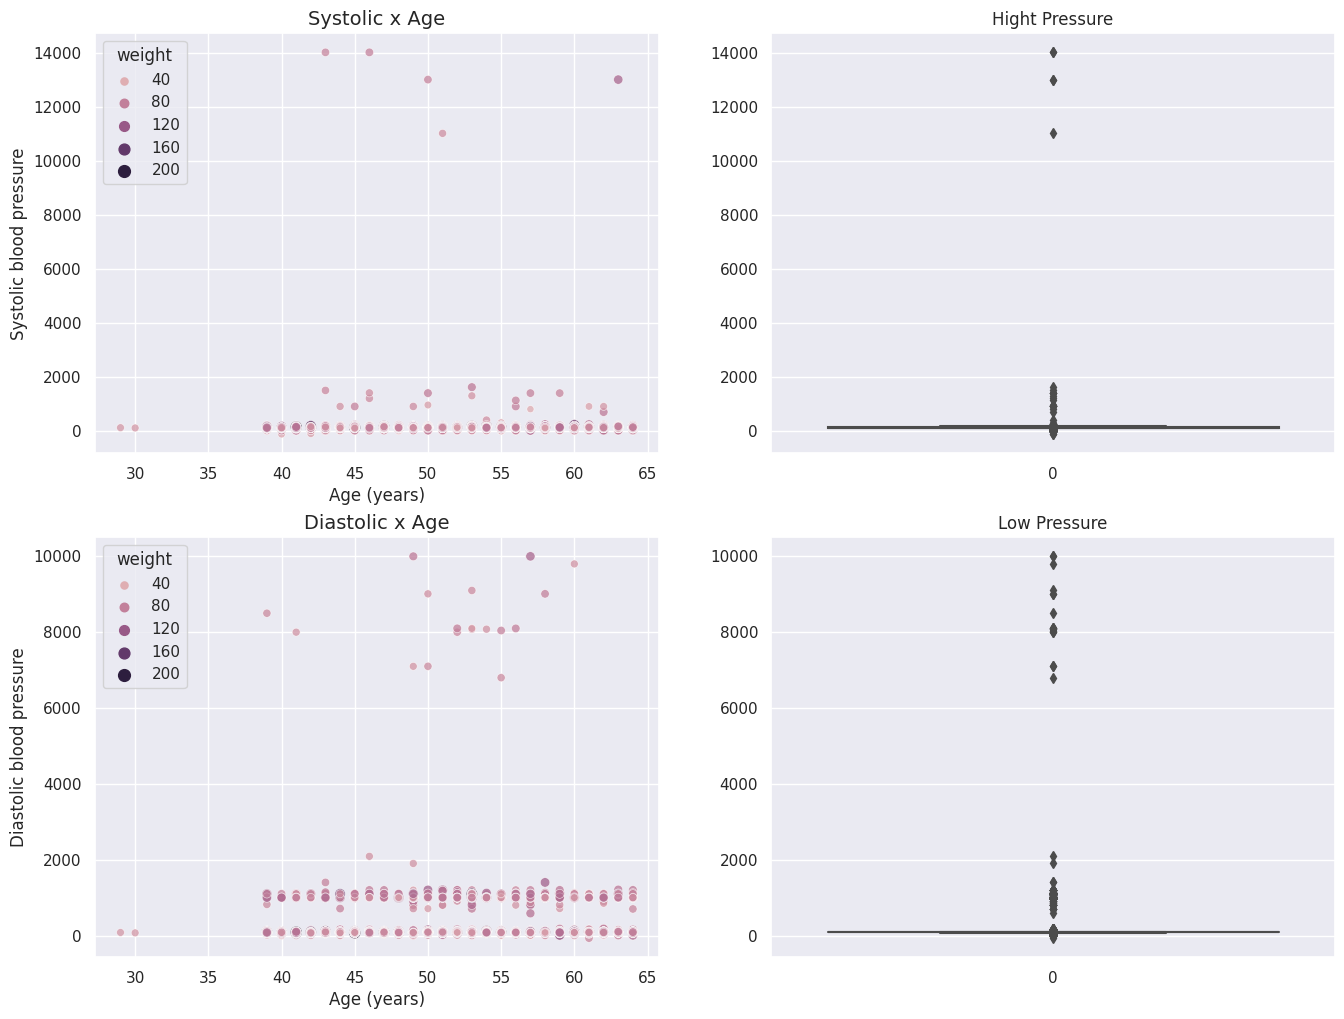

In [214]:
# sets plot size
plt.figure(figsize=(16,12))

# plots scatterplot
plt.subplot(2,2,1)
sns.scatterplot(x='age', y='hight_pressure', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Systolic blood pressure")
plt.title("Systolic x Age", fontsize=14)

plt.subplot(2,2,3)
sns.scatterplot(x='age', y='low_pressure', data=df1, hue='weight', size='weight', alpha=0.75)
plt.xlabel("Age (years)")
plt.ylabel("Diastolic blood pressure")
plt.title("Diastolic x Age", fontsize=14)

plt.subplot(2,2,2)
plt.title('Hight Pressure')
sns.boxplot(df1['hight_pressure']);

plt.subplot(2,2,4)
plt.title('Low Pressure')
sns.boxplot(df1['low_pressure']);

# displays the plot
plt.show()

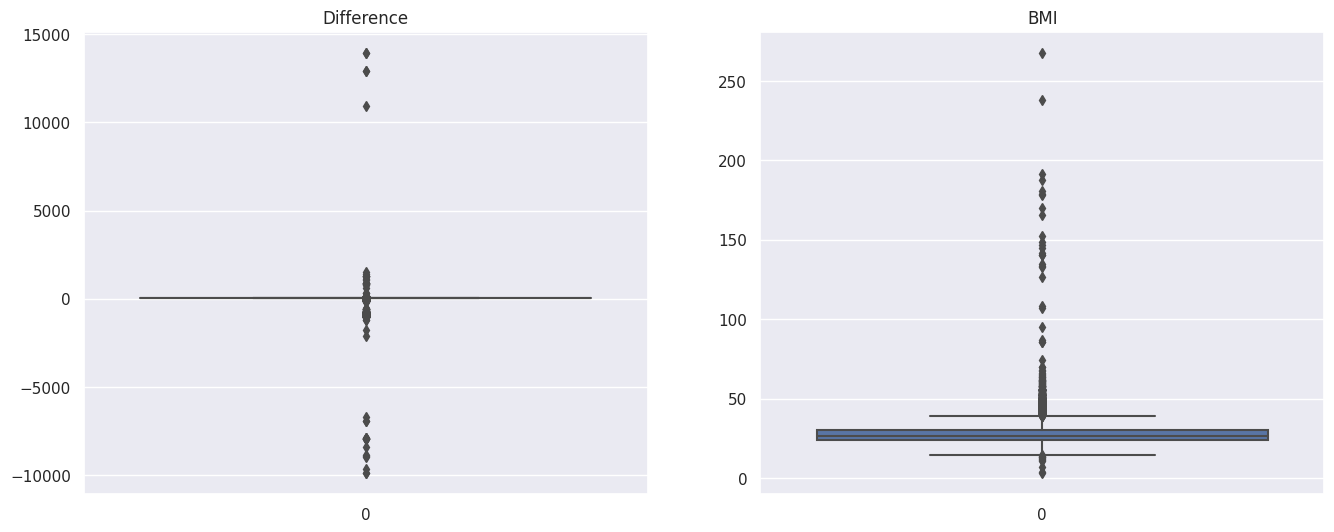

In [215]:
# Boxplot from numerical data
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.title('Difference')
sns.boxplot(df1['difference']);

plt.subplot(1,2,2)
plt.title('BMI')
sns.boxplot(df1['bmi']);



#### 2.3.1  Inconsistent numbers of **hight pressure** and **low pressure** 


In [216]:
# calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['hight_pressure'], .25)
Q3 = np.quantile(df1['hight_pressure'], .75)
IQR = Q3 - Q1

# calculates the outliers boundaries through statistical relationship
low_outliers_h = Q1 - 1.5 * IQR
high_outliers_h = Q3 + 1.5 * IQR

print("Systolic boundaries for outliers")
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers_h}\nhigh_outliers = {high_outliers_h}")


# calculates Q1, Q3 and IQR
Q1 = np.quantile(df1['low_pressure'], .25)
Q3 = np.quantile(df1['low_pressure'], .75)
IQR = Q3 - Q1

# calculates the outliers boundaries through statistical relationship
low_outliers_l = Q1 - 1.5 * IQR
high_outliers_l = Q3 + 1.5 * IQR

print("\nDiastolic boundaries for outliers")
print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers_l}\nhigh_outliers = {high_outliers_l}")

Systolic boundaries for outliers
Q1 = 120.0
Q3 = 140.0
IQR = 20.0
low_outliers = 90.0
high_outliers = 170.0

Diastolic boundaries for outliers
Q1 = 80.0
Q3 = 90.0
IQR = 10.0
low_outliers = 65.0
high_outliers = 105.0


In [217]:

print(f'''{df1[(df1['low_pressure'] < low_outliers_l) | (
    df1['low_pressure'] > high_outliers_l)].shape[0]} inconsistent rows on low_pressure.''')
print(f'''{df1[(df1['hight_pressure'] < low_outliers_h) | (
    df1['hight_pressure'] > high_outliers_h)].shape[0]} inconsistent rows on hight_pressure. ''')

# #filtering data without inconsistence data
df1 = df1[(df1['low_pressure'] >= 20) & (df1['low_pressure'] <= 150)]
df1 = df1[(df1['hight_pressure'] >= 40) & (df1['hight_pressure'] <= 300)]

3486 inconsistent rows on low_pressure.
1055 inconsistent rows on hight_pressure. 


## 5.0 - EDA - Explolatory Data Analysis

In [218]:
df2=df1.copy()
df2.shape

(51593, 22)

### 5.1 - Univariate Analysis

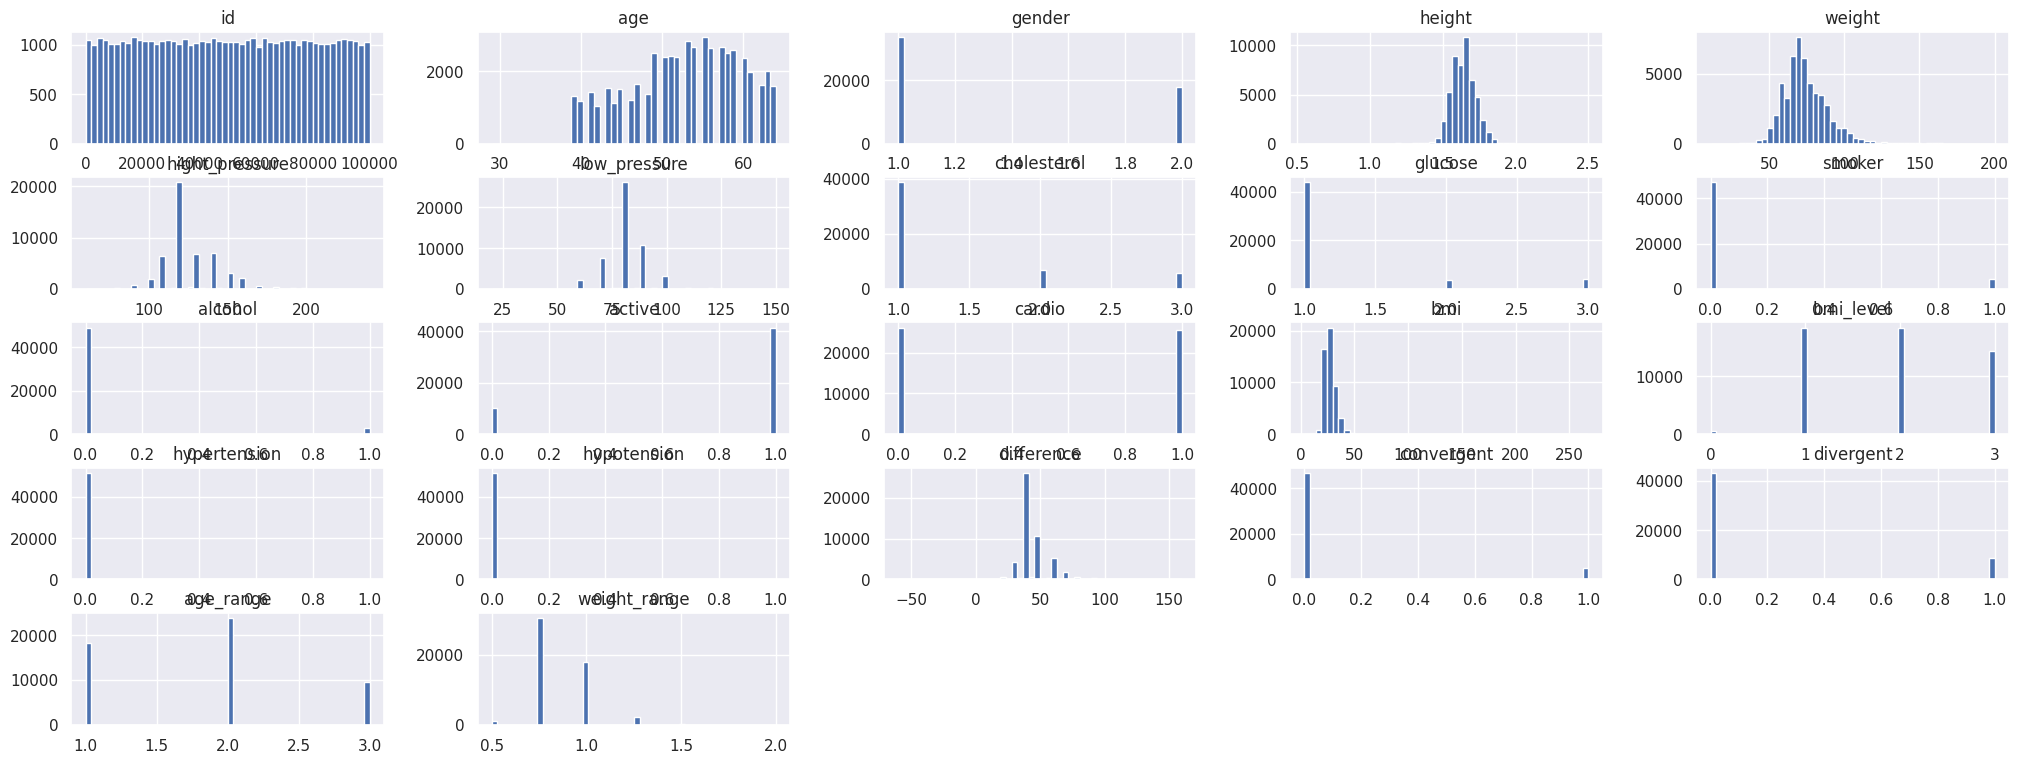

In [219]:
# Distribution from all data
df2.hist(bins=50);

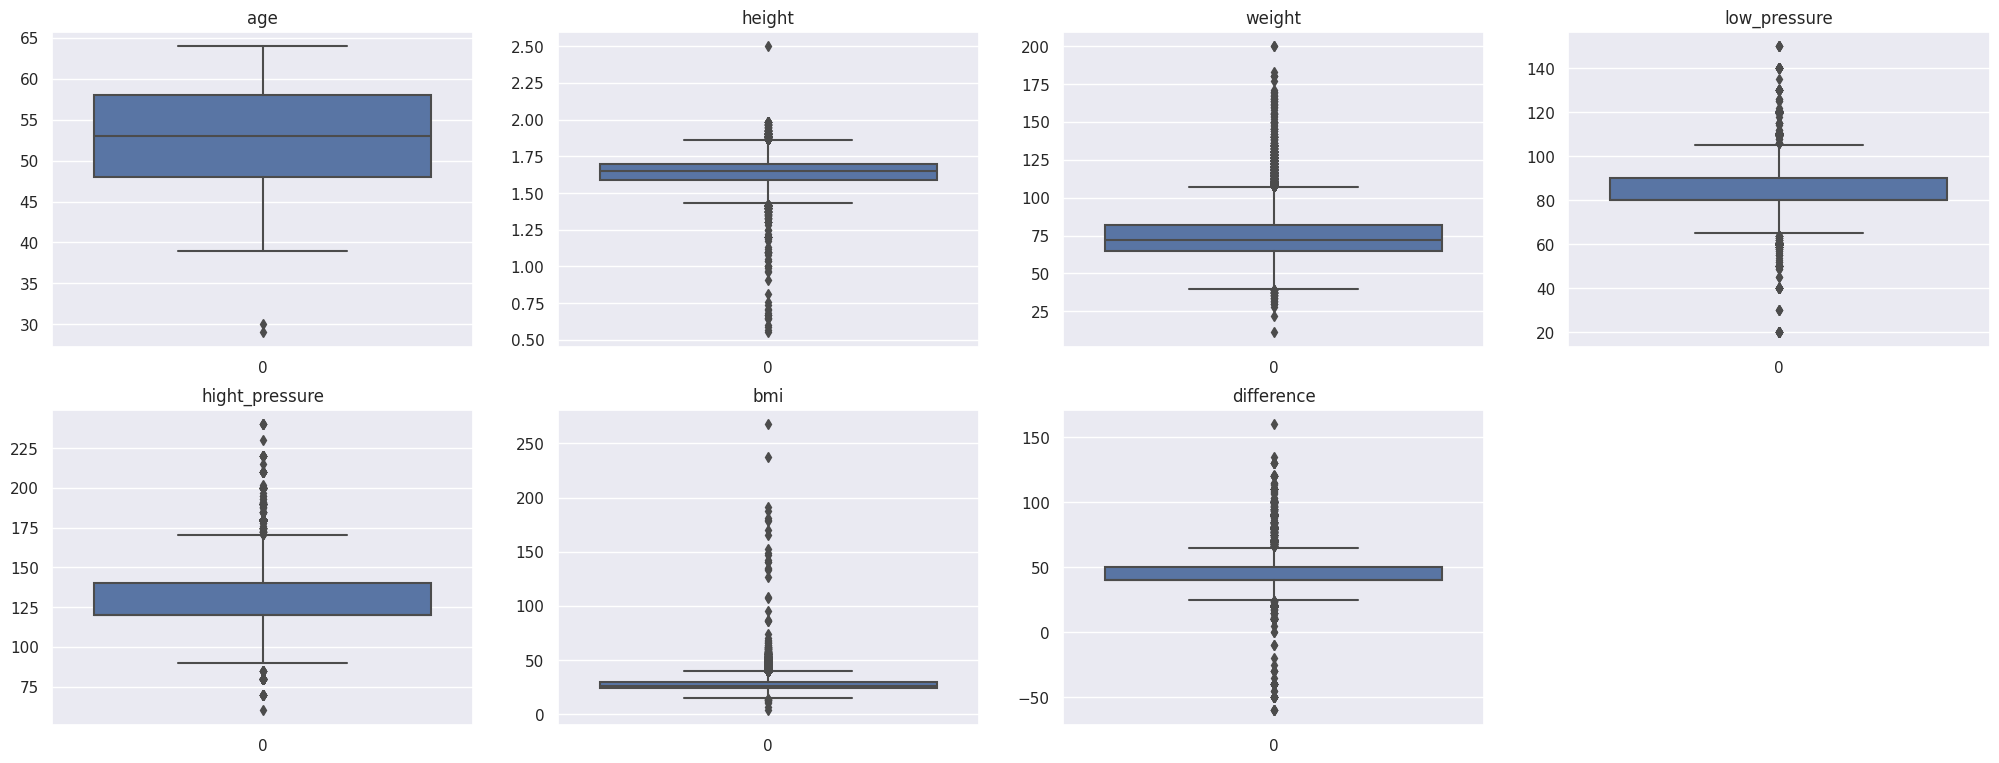

In [220]:
# Distribution from all data
plt.subplot(2,4,1)
plt.title('age')
sns.boxplot(df2['age']);

plt.subplot(2,4,2)
plt.title('height')
sns.boxplot(df2['height']);

plt.subplot(2,4,3)
plt.title('weight')
sns.boxplot(df2['weight']);

plt.subplot(2,4,4)
plt.title('low_pressure')
sns.boxplot(df2['low_pressure']);

plt.subplot(2,4,5)
plt.title('hight_pressure')
sns.boxplot(df2['hight_pressure']);

plt.subplot(2,4,6)
plt.title('bmi')
sns.boxplot(df2['bmi']);

plt.subplot(2,4,7)
plt.title('difference')
sns.boxplot(df2['difference']);


In [221]:
df2.columns

Index(['id', 'age', 'gender', 'height', 'weight', 'hight_pressure',
       'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active',
       'cardio', 'bmi', 'bmi_level', 'hypertension', 'hypotension',
       'difference', 'convergent', 'divergent', 'age_range', 'weight_range'],
      dtype='object')

### 5.2 - Bivariate Analysis

##### 5.2.1 - How more active, less diseases
False

In [222]:
df2[['cardio','active']].groupby('cardio').value_counts(normalize=True ).reset_index()

,cardio,active,0
0,0,1,0.816089
1,0,0,0.183911
2,1,1,0.788647
3,1,0,0.211353


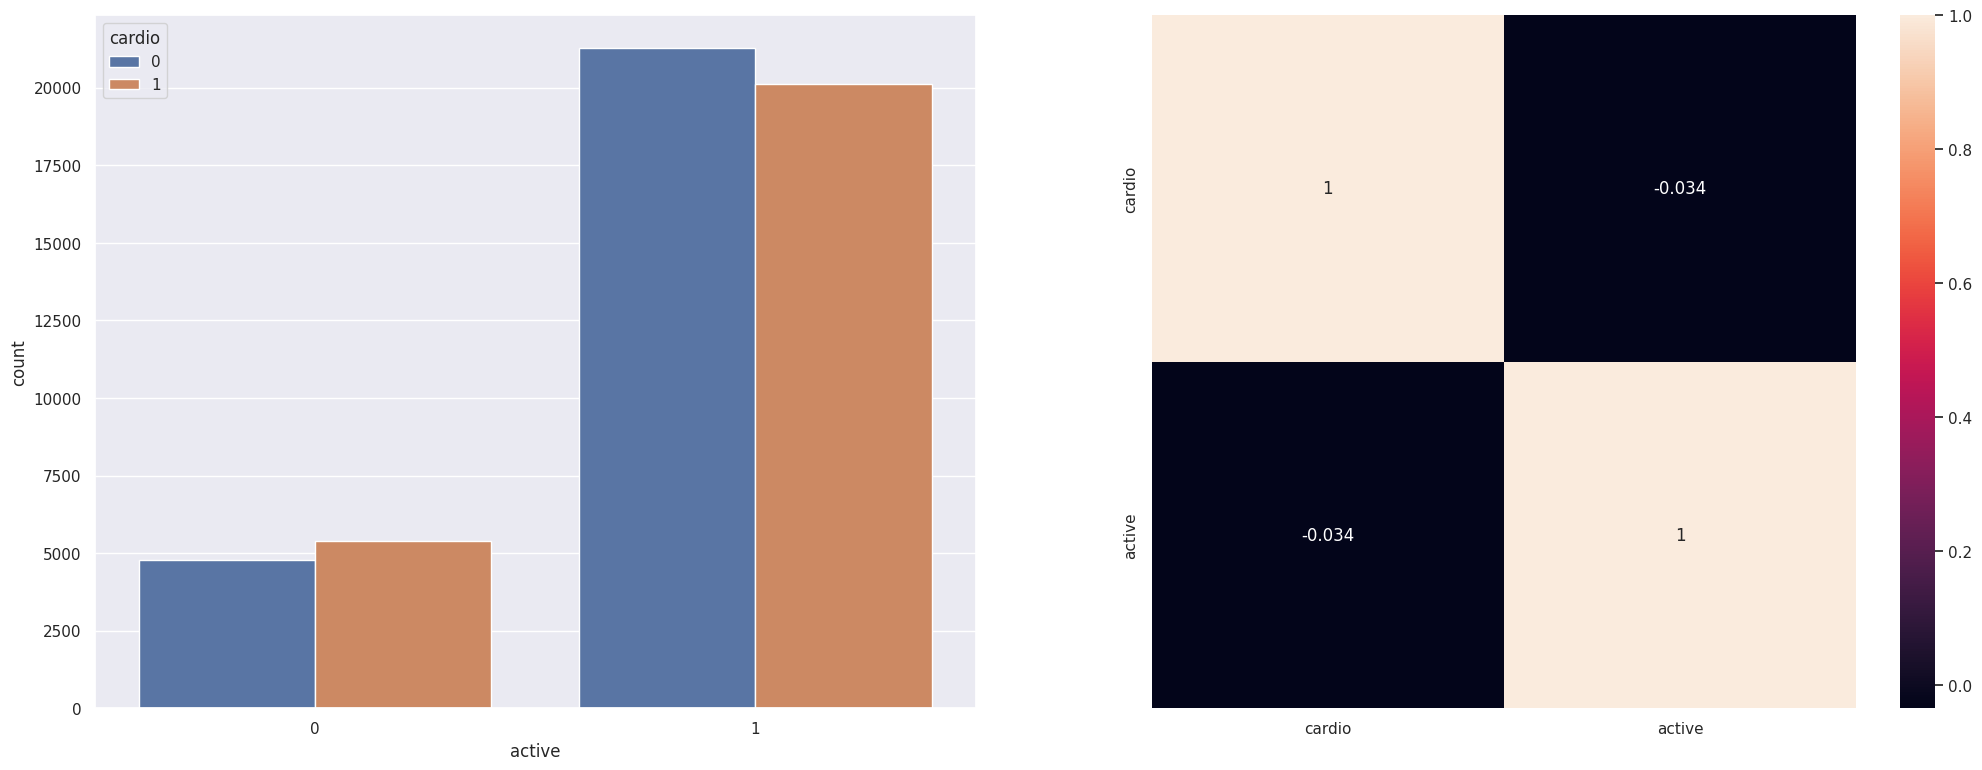

In [223]:
subplot(1,2,1)
sns.countplot(hue='cardio', x='active', data=df2);

subplot(1,2,2)
sns.heatmap(df2[['cardio','active']].corr(method='pearson'), annot=True);


##### 5.2.2 - Cholesterou over level I, more risk
 True (perarson >0.2)

In [224]:
df2[['cardio','cholesterol']].groupby('cardio').value_counts(normalize=True ).reset_index()

,cardio,cholesterol,0
0,0,1,0.836767
1,0,2,0.109219
2,0,3,0.054015
3,1,1,0.660346
4,1,3,0.176565
5,1,2,0.163089


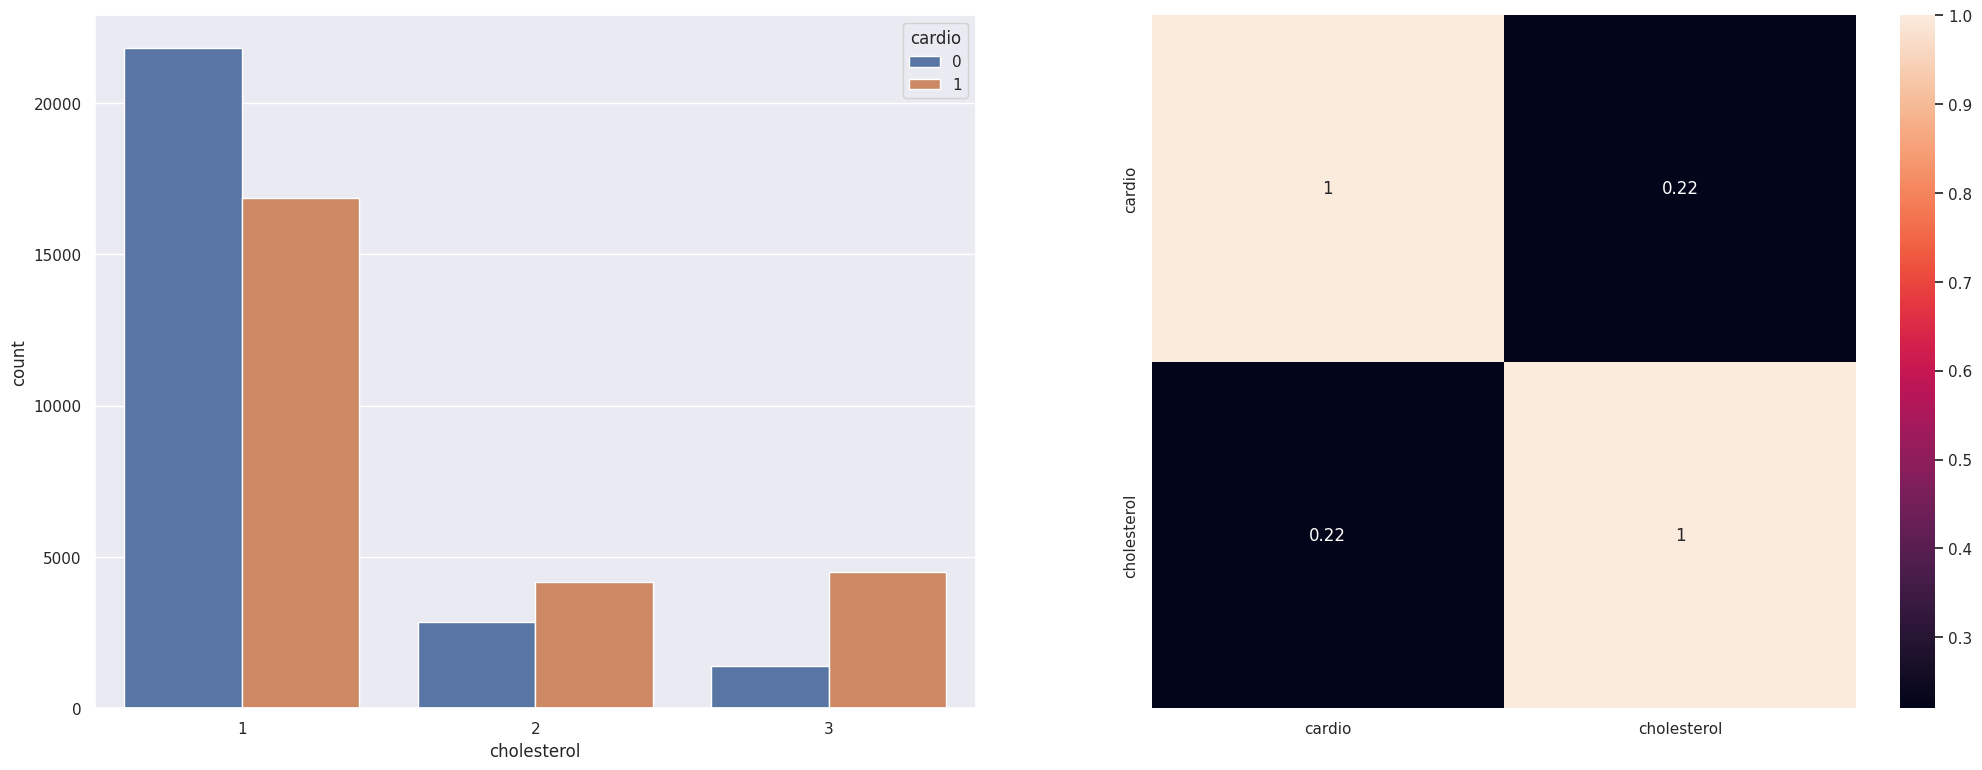

In [225]:
plt.subplot(1,2,1)
sns.countplot(hue='cardio', x='cholesterol', data=df2);

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio','cholesterol']].corr(method='pearson'), annot=True);


##### 5.2.3 - How more clucose, more risk
   False

The correlation it's so low, insignificat to model

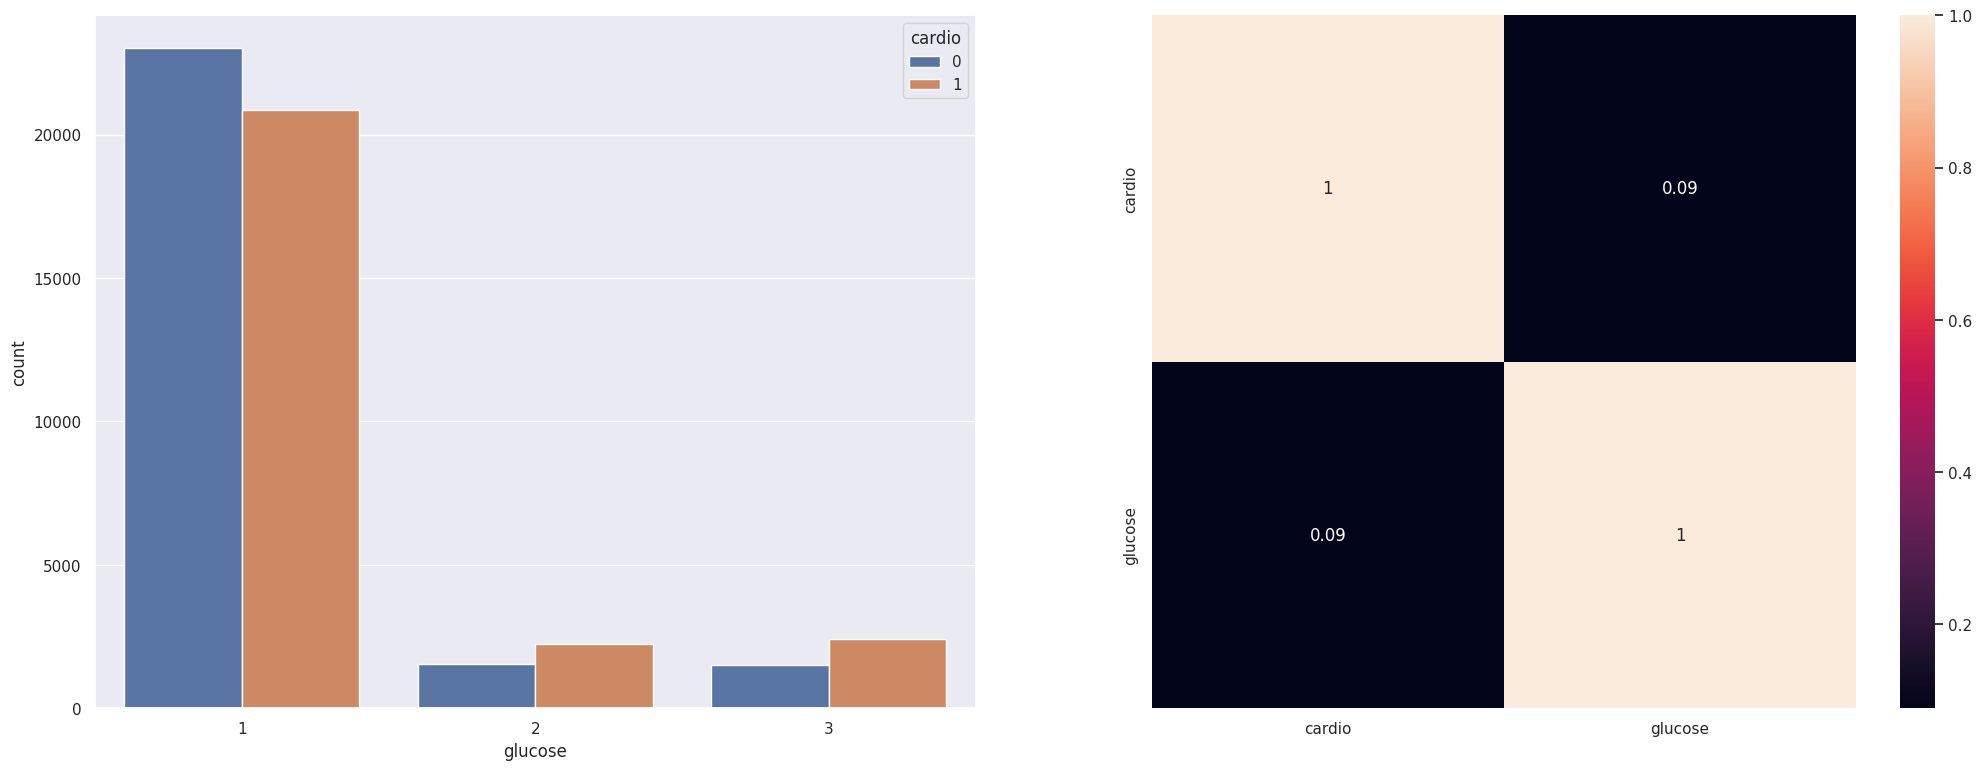

In [226]:
plt.subplot(1,2,1)
sns.countplot(hue='cardio', x='glucose', data=df2);

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio','glucose']].corr(method='pearson'), annot=True);

##### 5.2.4 - How more older, more risk
   True (perarson >0.2)

following the years it's more count and more avarage pear year old, low correlation, but, probly it's important to model

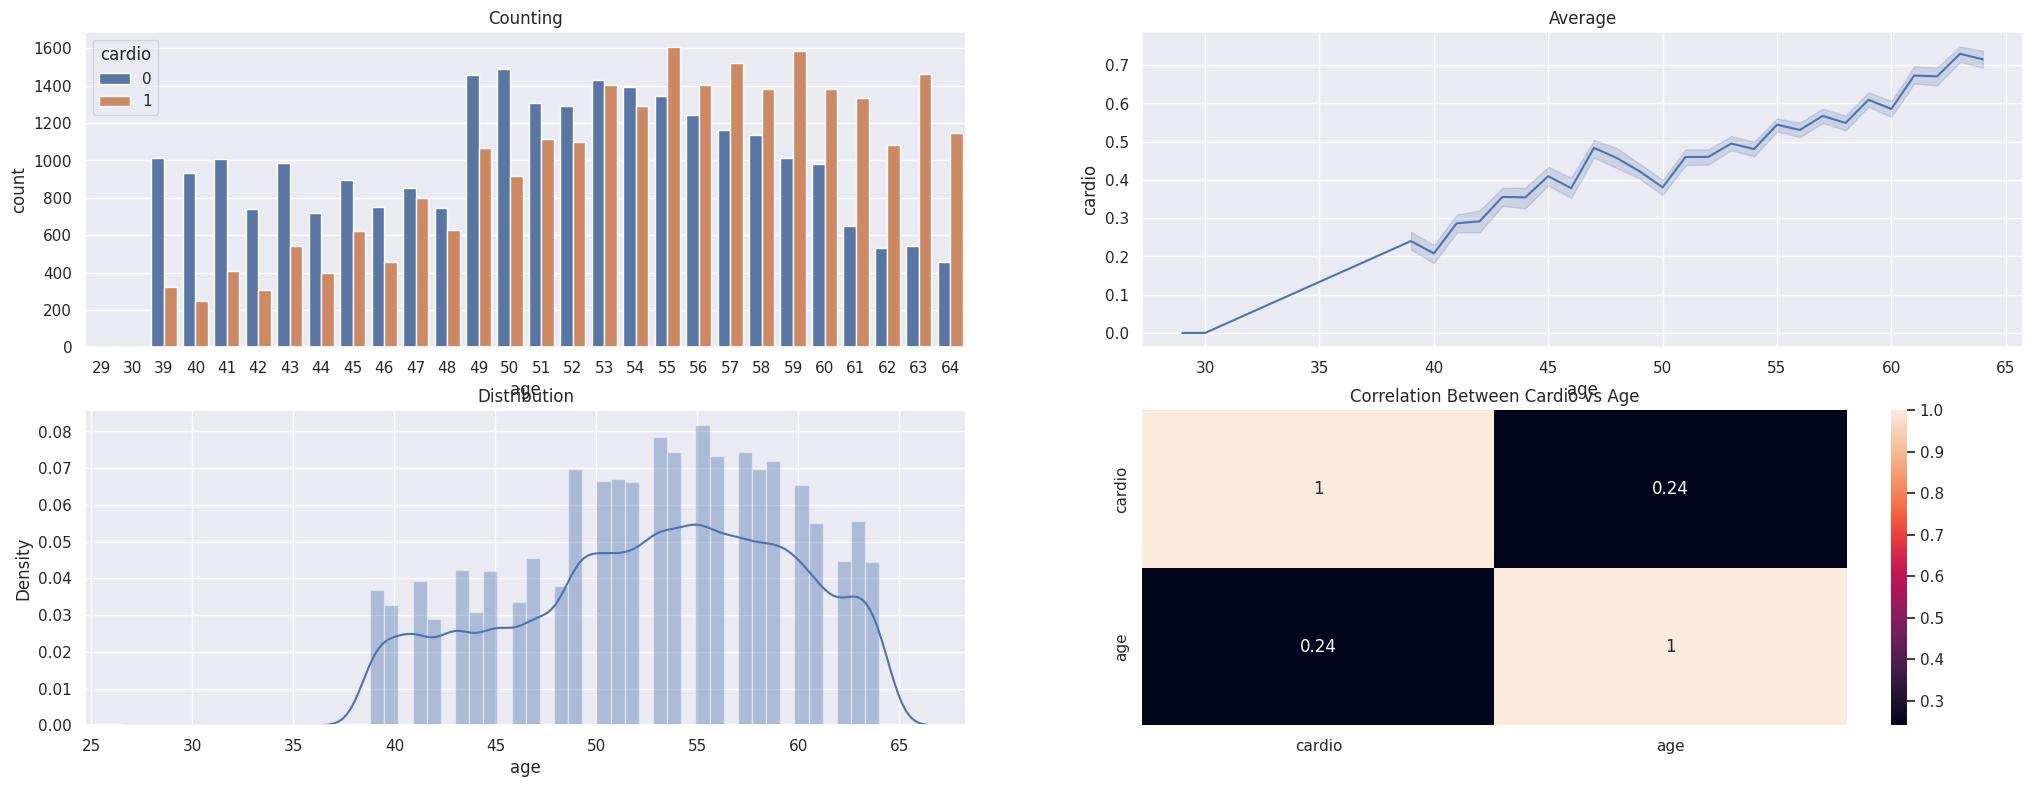

In [227]:
subplot(2,2,1)
plt.title('Counting')
sns.countplot(x='age', hue='cardio', data=df2);

subplot(2,2,2)
plt.title('Average')
sns.lineplot(data=df2, x='age', y='cardio', estimator='mean');

subplot(2,2,3)
plt.title('Distribution')
sns.distplot(df2['age']);

subplot(2,2,4)
plt.title('Correlation Between Cardio vs Age')
sns.heatmap(df2[['cardio', 'age']].corr('pearson'), annot=True);

##### 5.2.5 - Over 60 year old with Hypertension, more risk
   False

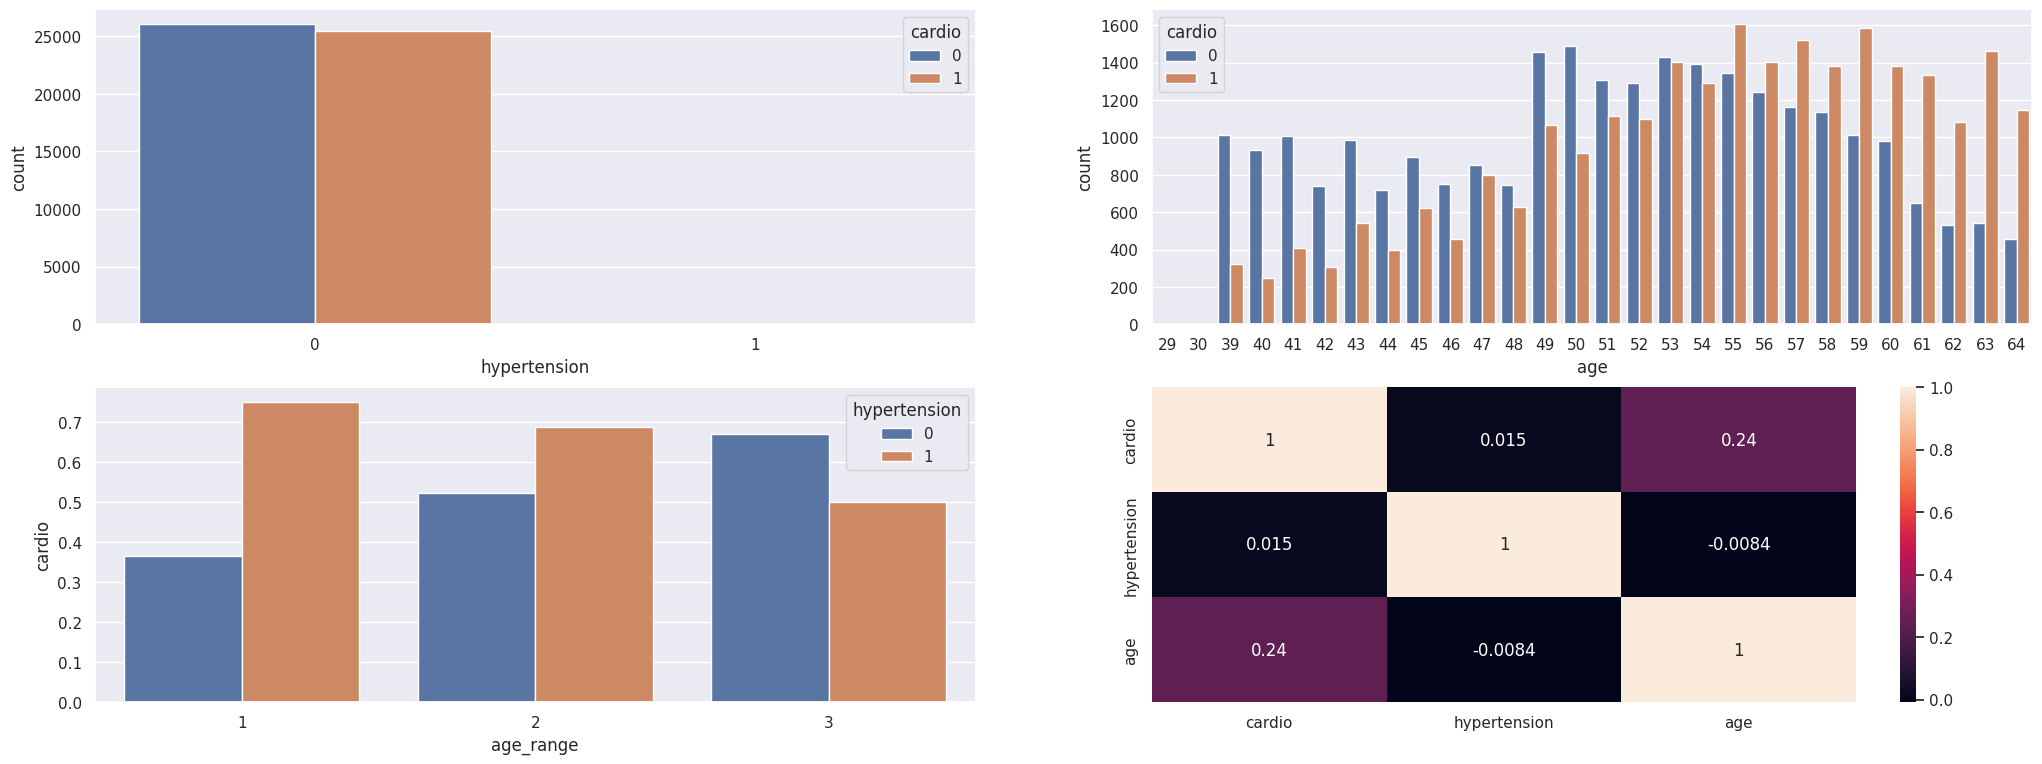

In [228]:
aux = df2[['age_range', 'cardio']].groupby('age_range').mean().reset_index()
aux1 = df2[['cardio', 'age_range', 'hypertension']]

plt.subplot(2,2,1)
sns.countplot(hue='cardio', x='hypertension', data=aux1);

plt.subplot(2,2,2)
sns.countplot(x='age', hue='cardio', data=df2);

# Average incidence of diseases by hypertension and over 60 year.
subplot(2,2,3)
aux = df2[['hypertension', 'cardio', 'age_range']].groupby(['hypertension', 'age_range']).mean().reset_index()
sns.barplot(x='age_range', y='cardio', hue='hypertension', data=aux);

subplot(2,2,4)
sns.heatmap(df2[['cardio', 'hypertension', 'age']].corr('pearson'), annot=True);

##### 5.2.6 - 60 year old with Hypotension, more risk
   False

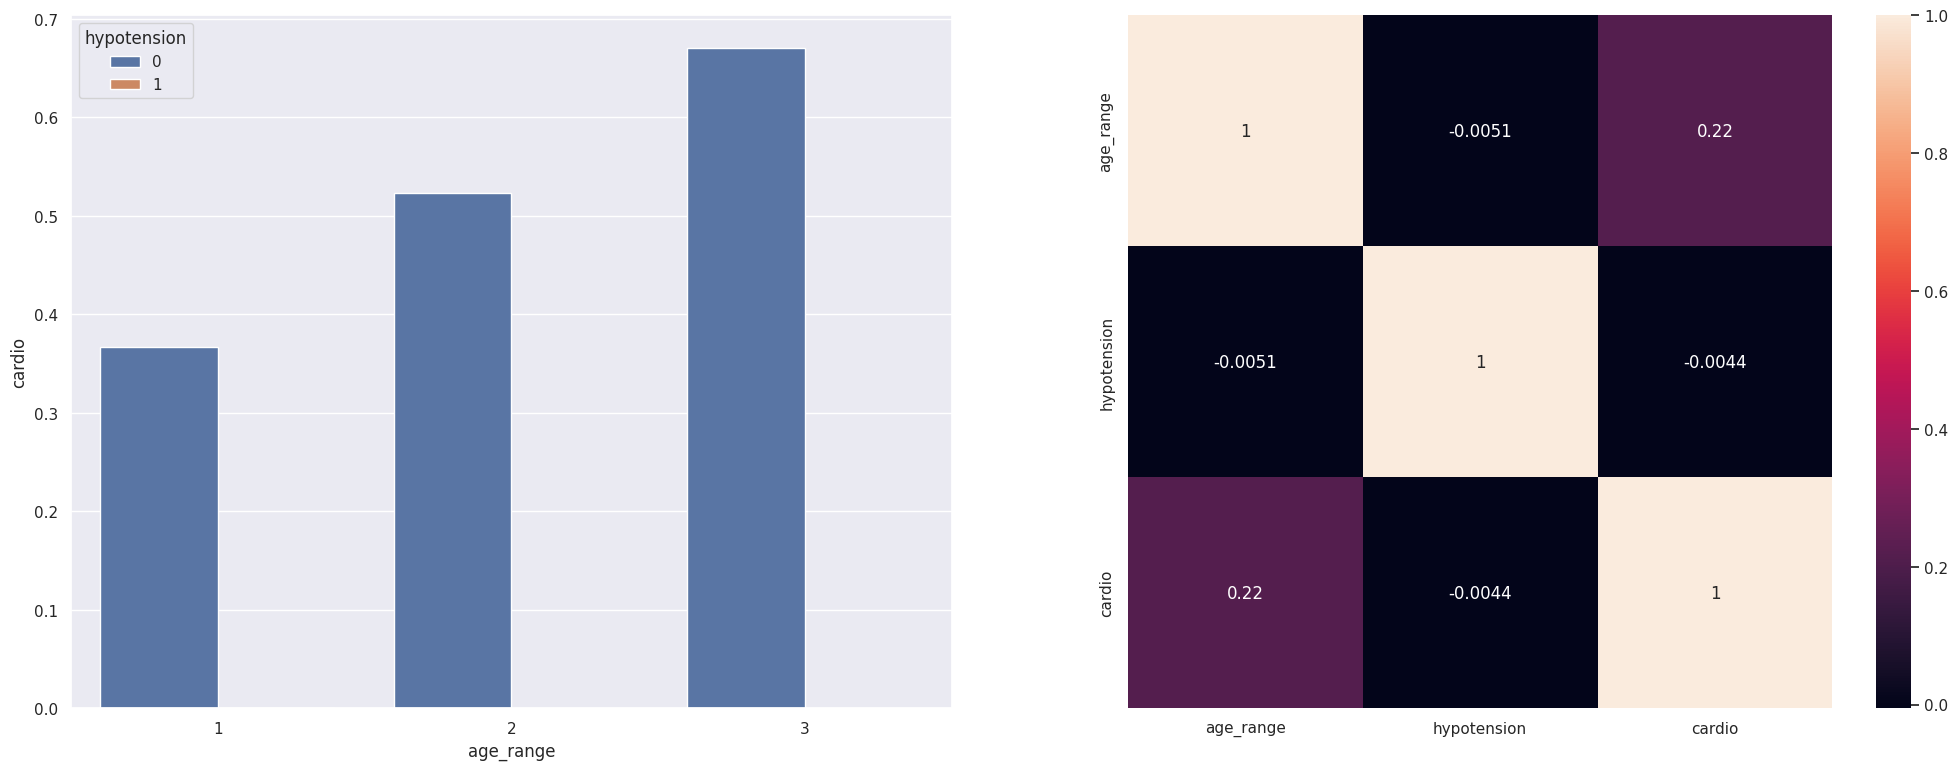

In [229]:
aux = df2[['hypotension', 'age_range', 'cardio']].groupby(
    ['hypotension', 'age_range']).mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='age_range', y='cardio', hue='hypotension', data=aux);


plt.subplot(1,2,2)
sns.heatmap(df2[['age_range', 'hypotension', 'cardio']].corr('pearson'), annot=True);

##### 5.2.7 - 60 year old, more risk
   False

In [230]:
df2[['cardio','age_range']].groupby('cardio').value_counts(normalize=True ).reset_index()

,cardio,age_range,0
0,0,1,0.444432
1,0,2,0.434381
2,0,3,0.121188
3,1,2,0.486249
4,1,1,0.262399
5,1,3,0.251352


##### 5.2.8 - Divergent AP, more risk
   True - Relevant variable

<Axes: >

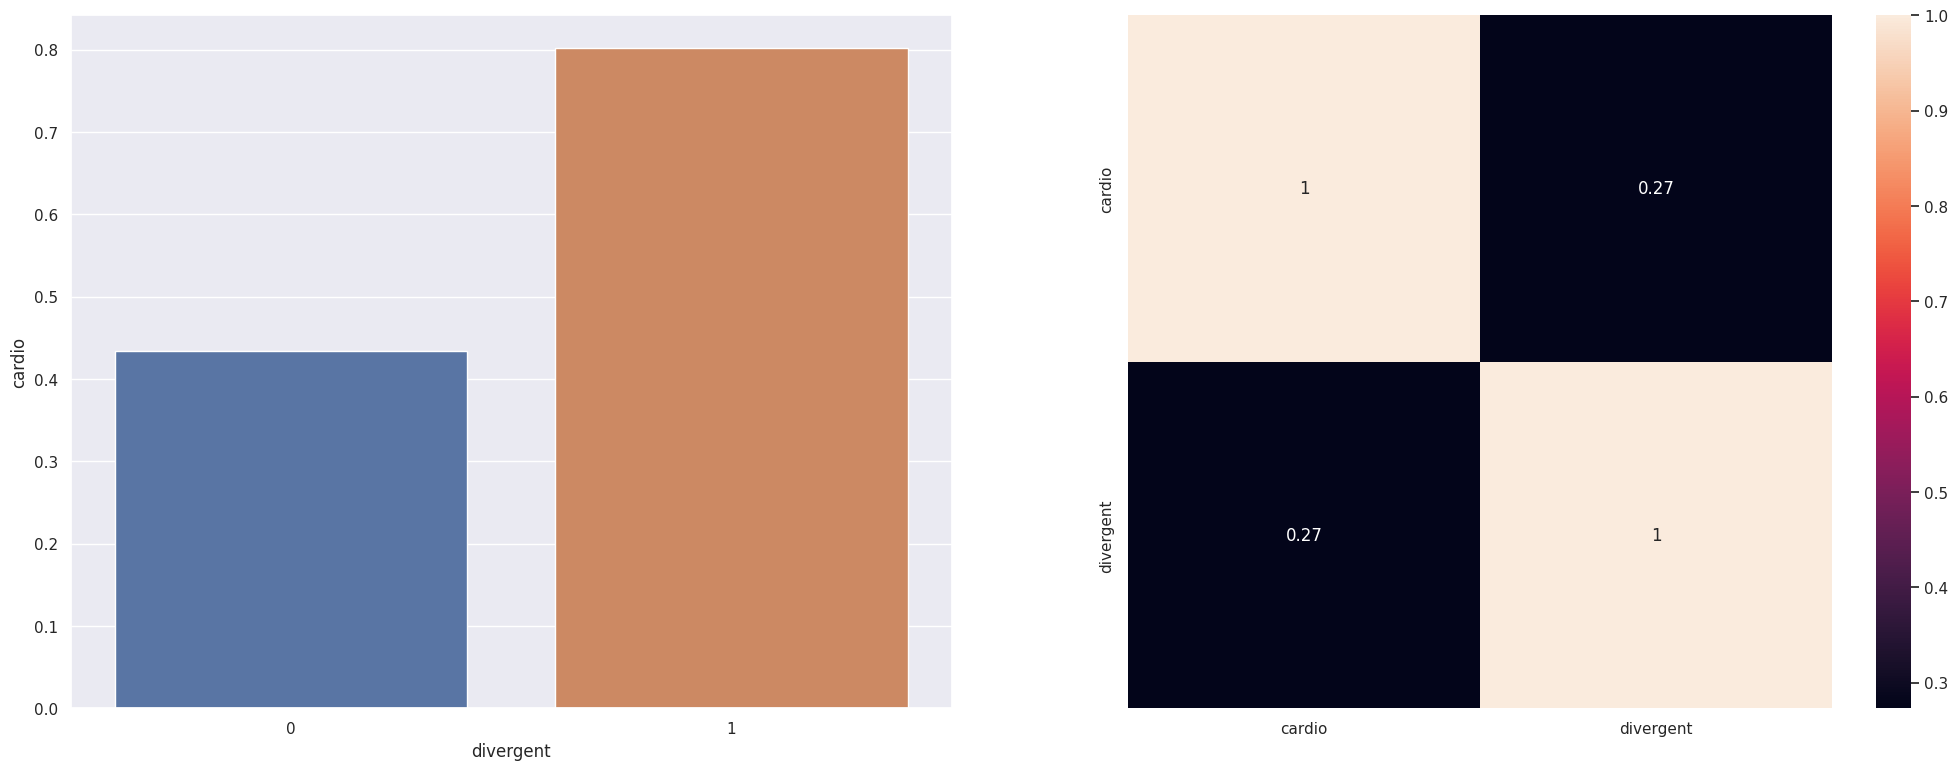

In [231]:
aux = df2[['divergent', 'cardio']].groupby('divergent').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='divergent', y='cardio', data=aux)

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio', 'divergent']].corr('pearson'), annot=True)

##### 5.2.9 - Convergent AP, more risk
   False

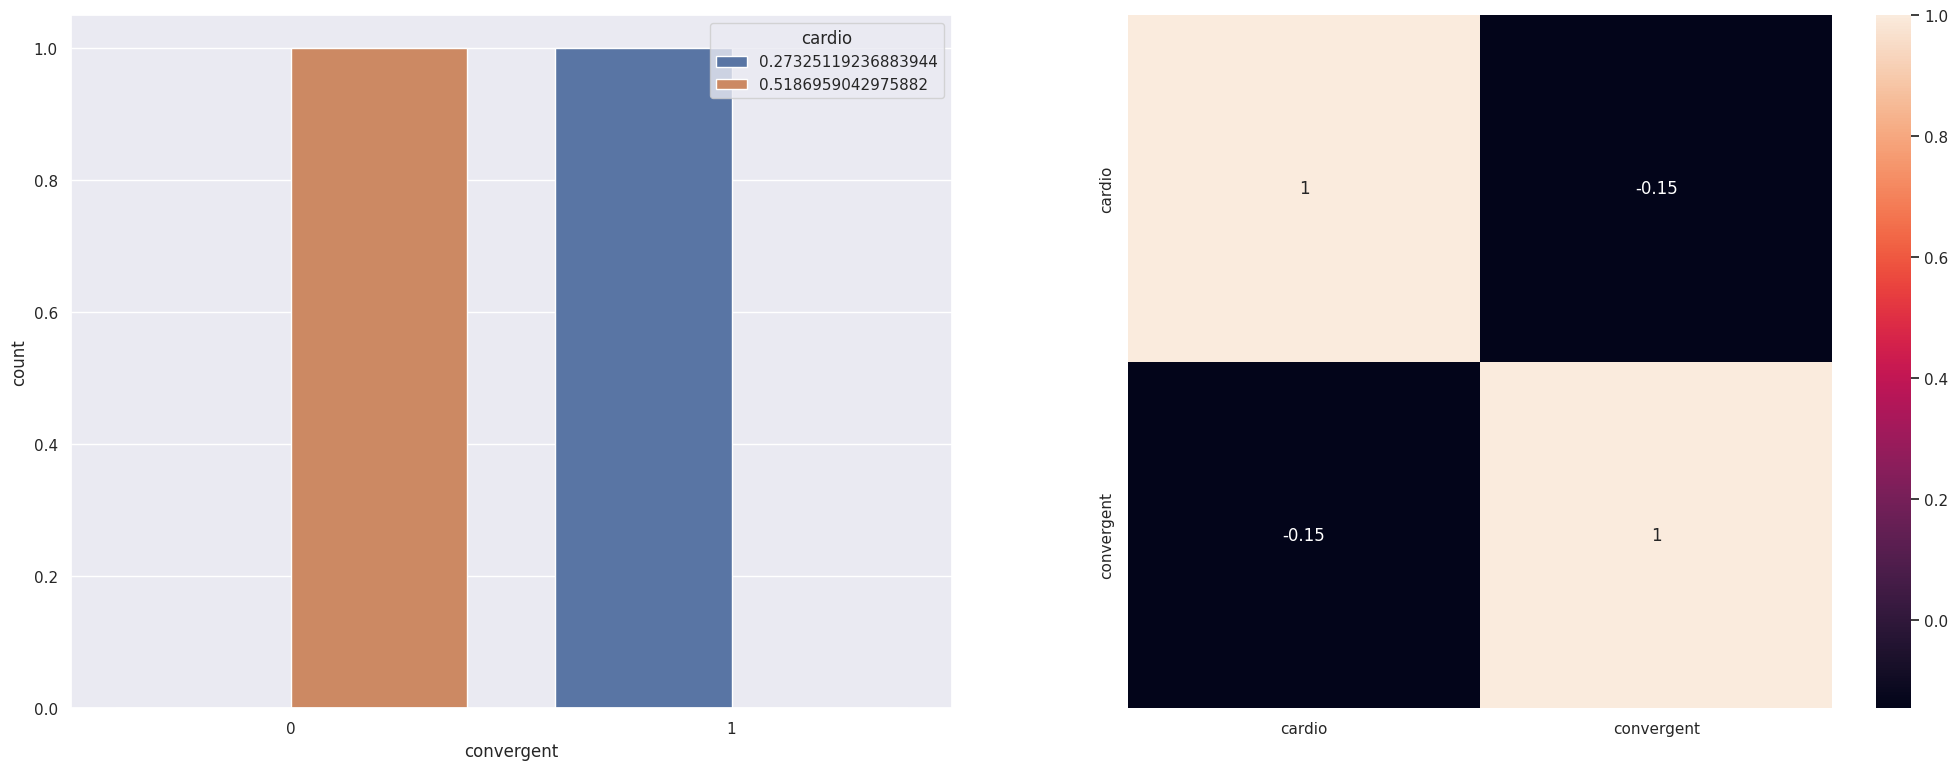

In [232]:
plt.subplot(1,2,1)
sns.countplot(x='convergent', hue='cardio',
    data=df2[['cardio', 'convergent']].groupby('convergent').mean().reset_index());

plt.subplot(1,2,2)
sns.heatmap(df2[['cardio', 'convergent']].corr('pearson'), annot=True);

##### 5.2.10 - Hypertension, more risk
   True

Average incidence by Hypertension

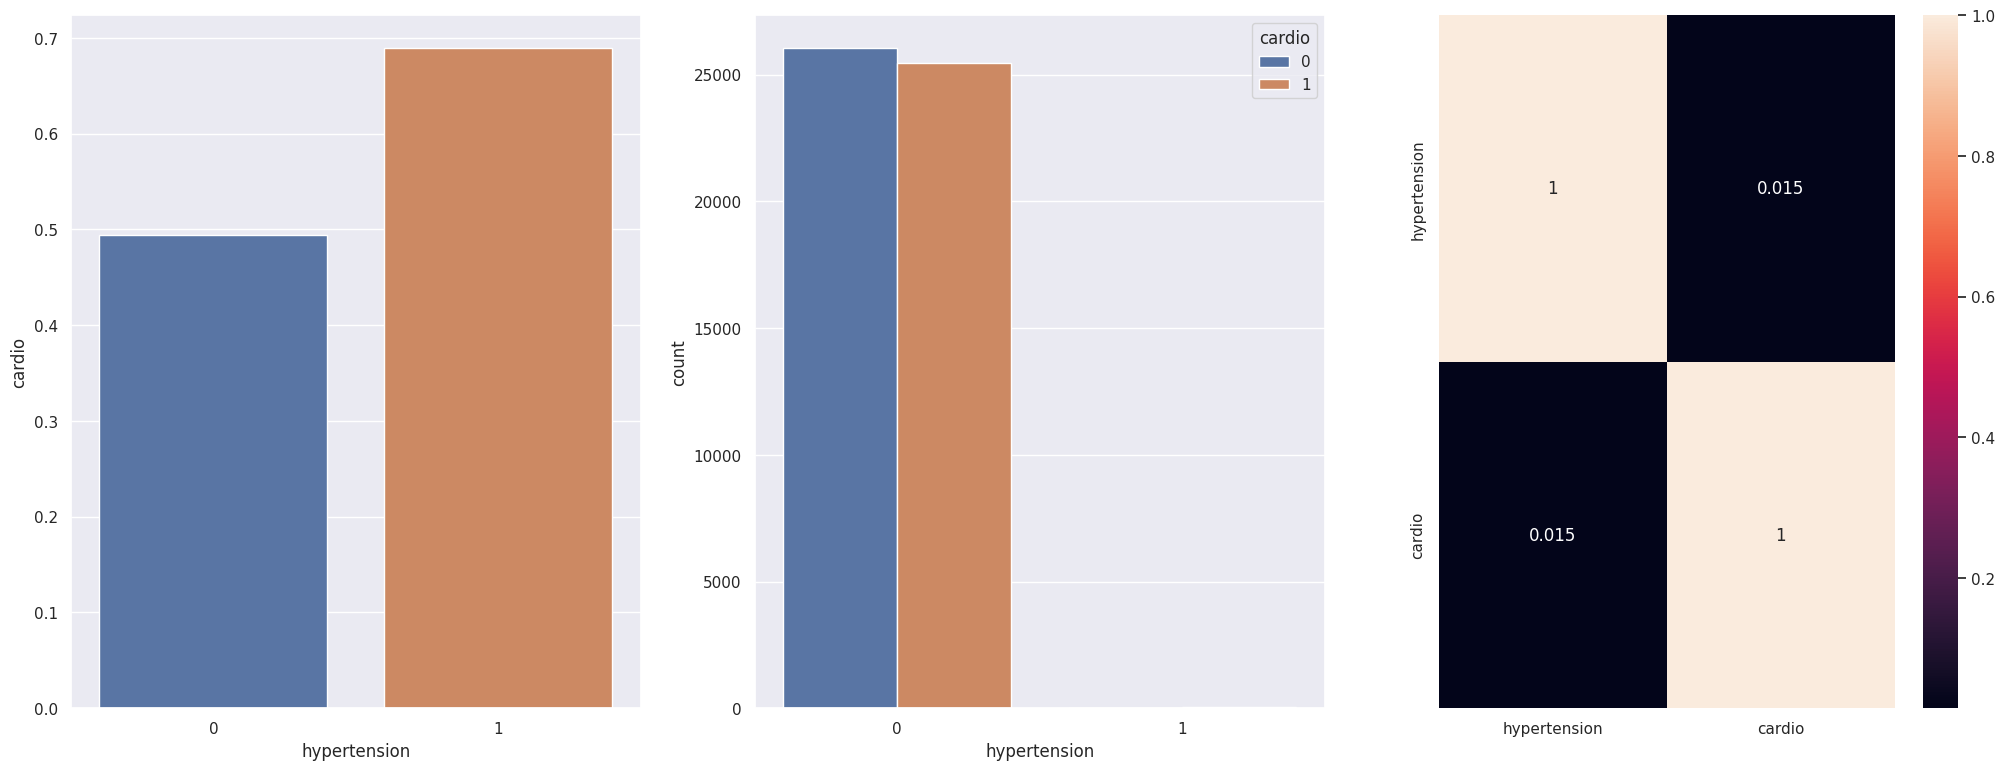

In [233]:
aux = df2[['hypertension', 'cardio']].groupby('hypertension').mean().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='hypertension', y='cardio', data=aux);

plt.subplot(1,3,2)
sns.countplot(x='hypertension', hue='cardio', data=df2);

plt.subplot(1,3,3)
sns.heatmap(df2[['hypertension', 'cardio']].corr('pearson'), annot=True);

In [234]:
# Hypertension percentual
df2['hypertension'].value_counts()


0    51519
1       74
Name: hypertension, dtype: int64

##### 5.2.11 - Hypotension, more risk
   False

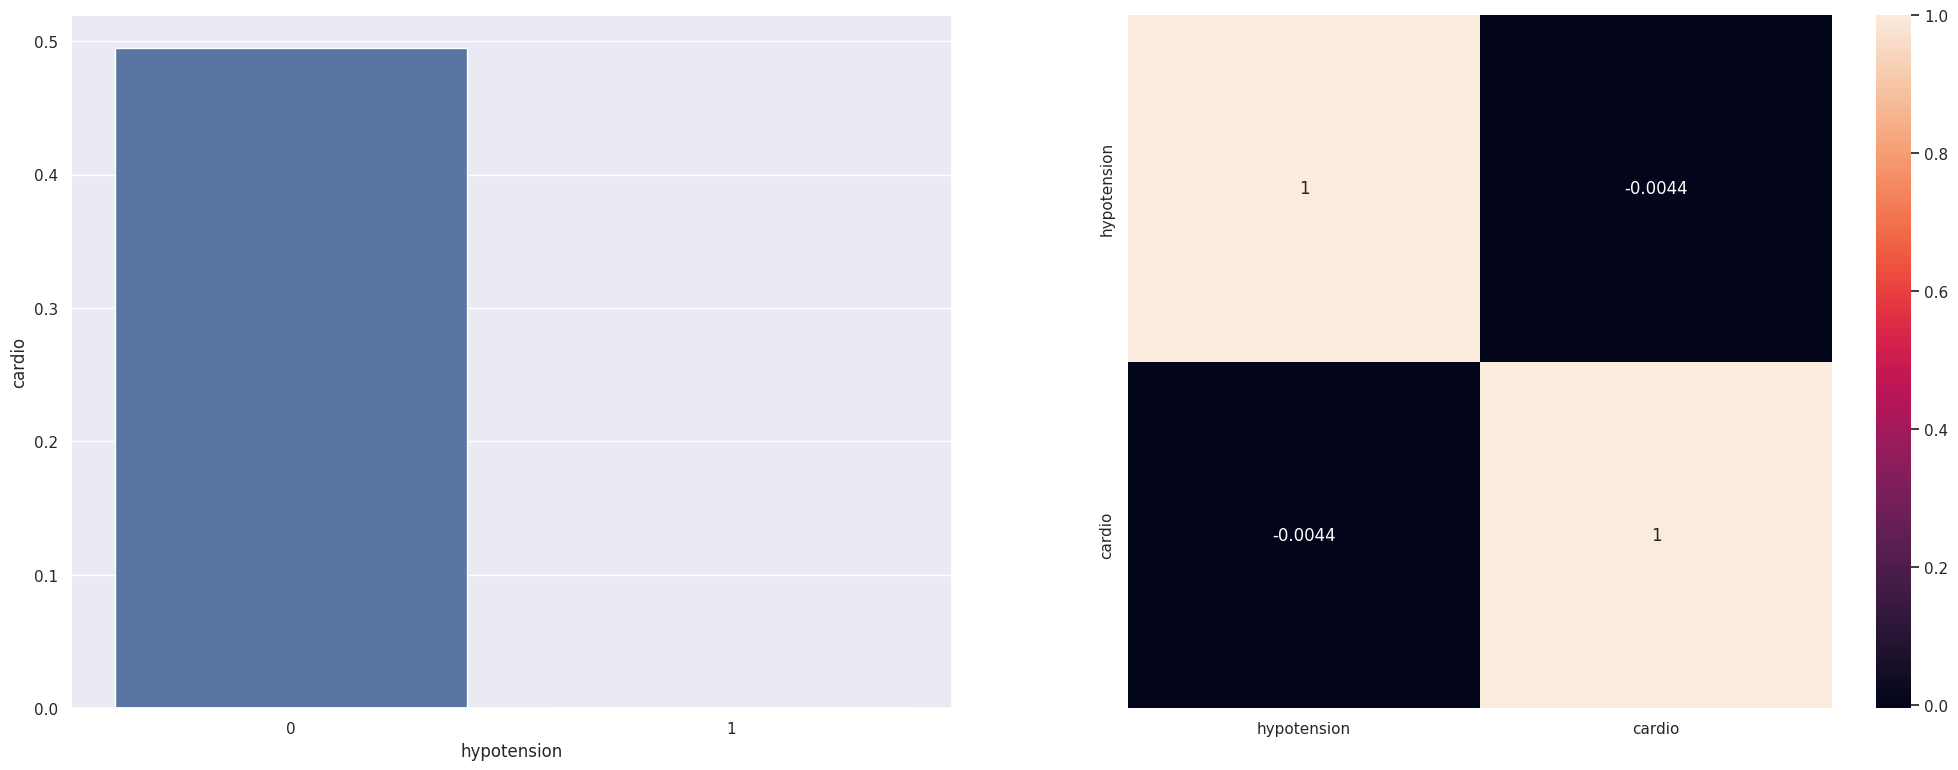

In [235]:
aux = df2[['hypotension', 'cardio']].groupby('hypotension').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='hypotension', y='cardio', data=aux);

plt.subplot(1,2,2)
sns.heatmap(df2[['hypotension', 'cardio']].corr('pearson'), annot=True);

In [236]:
df2['hypotension'].value_counts()

0    51592
1        1
Name: hypotension, dtype: int64

##### 5.2.12 - BMI - Obesity, more risk
   True

   bmi_level  cardio         0
0          0       0  0.725773
1          0       1  0.274227
2          1       0  0.604778
3          1       1  0.395222
4          2       1  0.504854
5          2       0  0.495146
6          3       1  0.616395
7          3       0  0.383605
   bmi_level    cardio
0          0  0.274227
1          1  0.395222
2          2  0.504854
3          3  0.616395


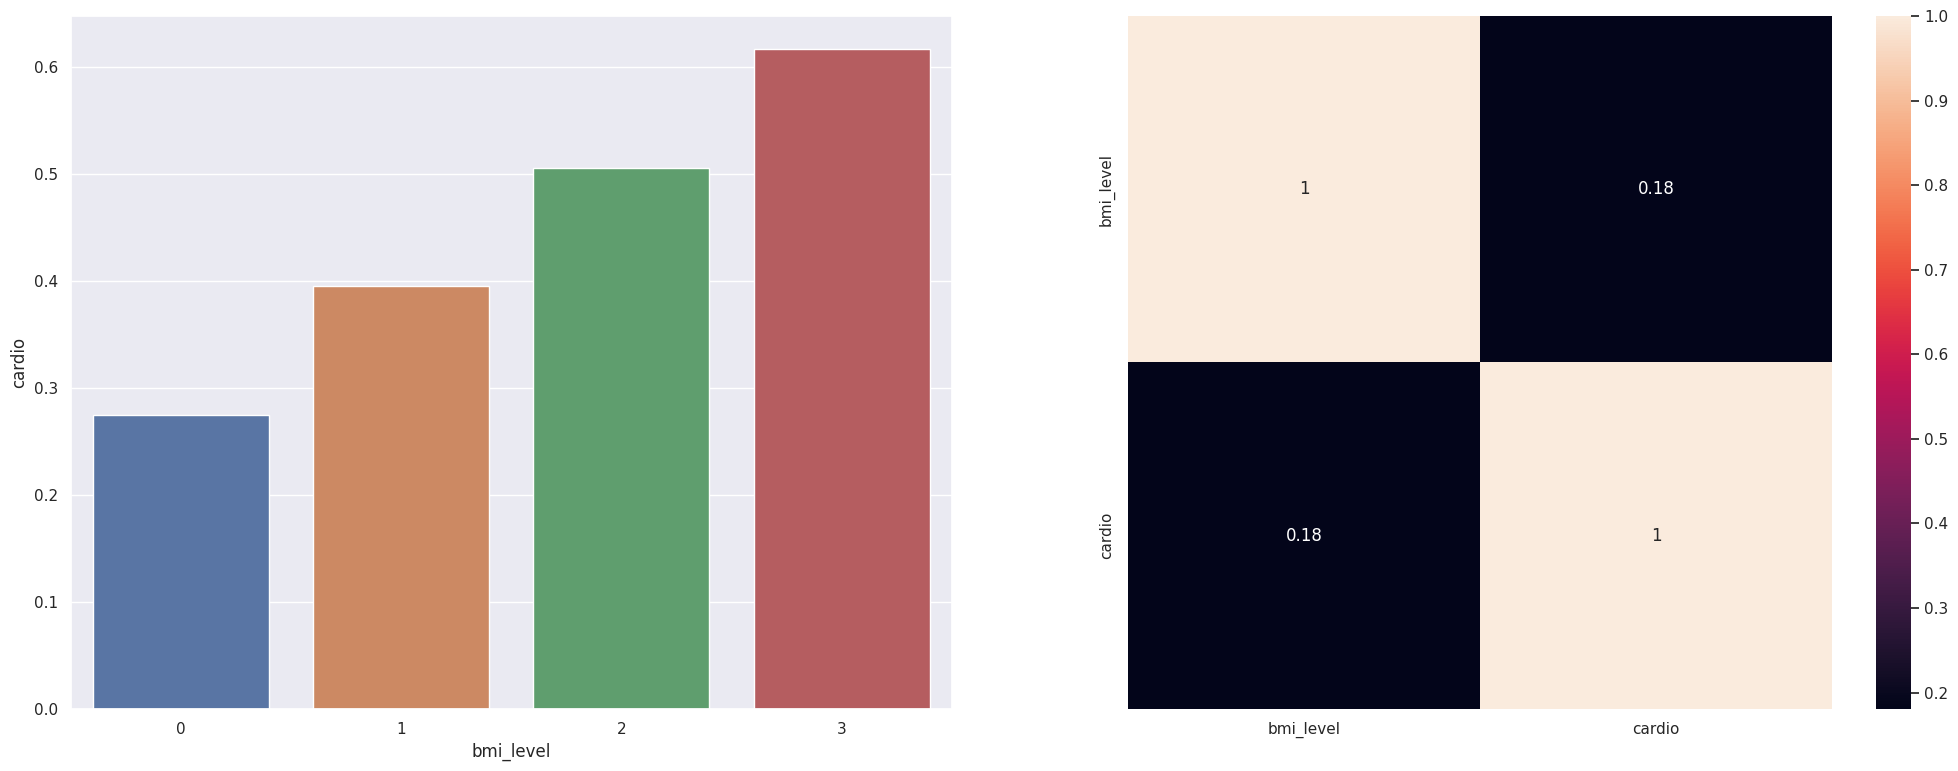

In [237]:
aux = df2[['bmi_level', 'cardio']].groupby('bmi_level').value_counts(normalize=True).reset_index()
print(aux)
aux = df2[['bmi_level', 'cardio']].groupby('bmi_level').mean().reset_index()
print(aux)

plt.subplot(1,2,1)
sns.barplot(x='bmi_level', y='cardio' ,data=aux);

plt.subplot(1,2,2)
sns.heatmap(df2[['bmi_level', 'cardio']].corr('pearson'), annot=True);

# aux1 = df2[(df2['cardio'] ==1)]
# aux2 = df2[(df2['cardio'] ==2) ]


##### 5.2.13 - Gender 2 has more risk
   False

In [238]:
aux = df2[['gender', 'cardio']].groupby('gender').value_counts(normalize=True).reset_index()
print(aux)
aux = df2[['gender', 'cardio']].groupby('gender').mean().reset_index()
print(aux)

   gender  cardio         0
0       1       0  0.507602
1       1       1  0.492398
2       2       0  0.500809
3       2       1  0.499191
   gender    cardio
0       1  0.492398
1       2  0.499191


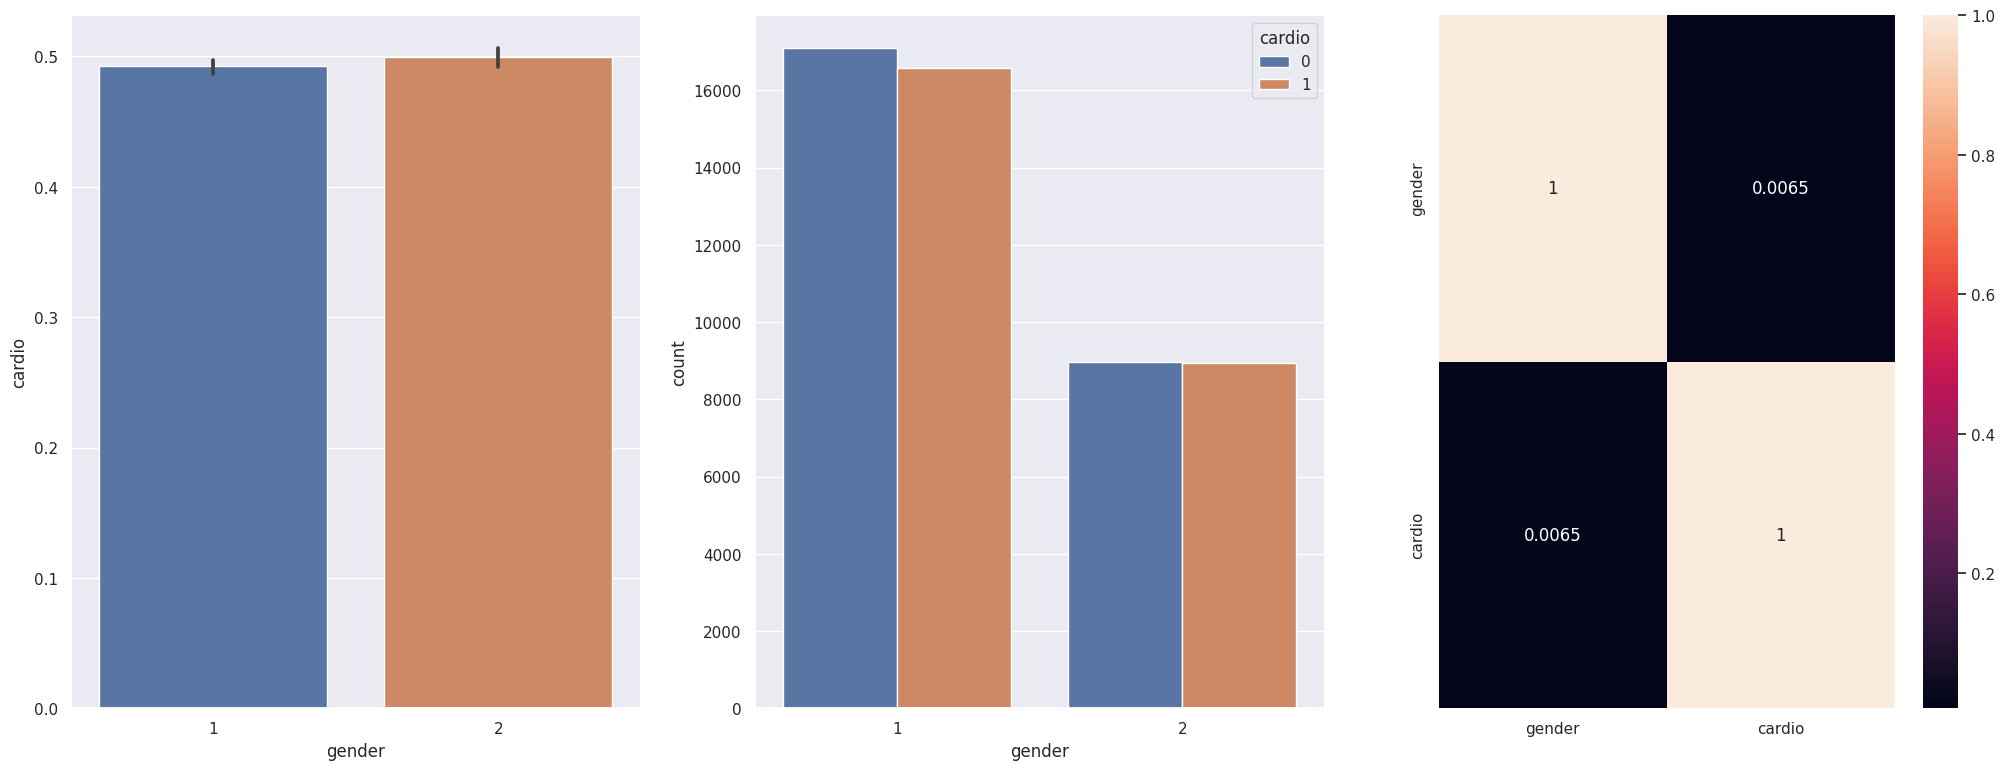

In [239]:
plt.subplot(1,3,1)
sns.barplot(x='gender', y='cardio', data=df2)
plt.subplot(1,3,2)
sns.countplot(x='gender', hue='cardio', data=df2 );
plt.subplot(1,3,3)
sns.heatmap(df2[['gender', 'cardio']].corr('pearson'), annot=True);


##### 5.2.14 - how more weith more risk
   True

In [240]:
aux = df2[['weight_range', 'cardio']].groupby('weight_range').value_counts(normalize=True).reset_index()
print(aux)
aux = df2[['weight_range', 'cardio']].groupby('weight_range').mean().reset_index()
print(aux)

    weight_range  cardio         0
0           0.50       0  0.710758
1           0.50       1  0.289242
2           0.75       0  0.560317
3           0.75       1  0.439683
4           1.00       1  0.575820
5           1.00       0  0.424180
6           1.25       1  0.687768
7           1.25       0  0.312232
8           1.50       1  0.722772
9           1.50       0  0.277228
10          1.75       1  0.580645
11          1.75       0  0.419355
12          2.00       1  0.700000
13          2.00       0  0.300000
   weight_range    cardio
0          0.50  0.289242
1          0.75  0.439683
2          1.00  0.575820
3          1.25  0.687768
4          1.50  0.722772
5          1.75  0.580645
6          2.00  0.700000


In [241]:
df2.isna().sum()

id                0
age               0
gender            0
height            0
weight            0
hight_pressure    0
low_pressure      0
cholesterol       0
glucose           0
smoker            0
alcohol           0
active            0
cardio            0
bmi               0
bmi_level         0
hypertension      0
hypotension       0
difference        0
convergent        0
divergent         0
age_range         0
weight_range      0
dtype: int64

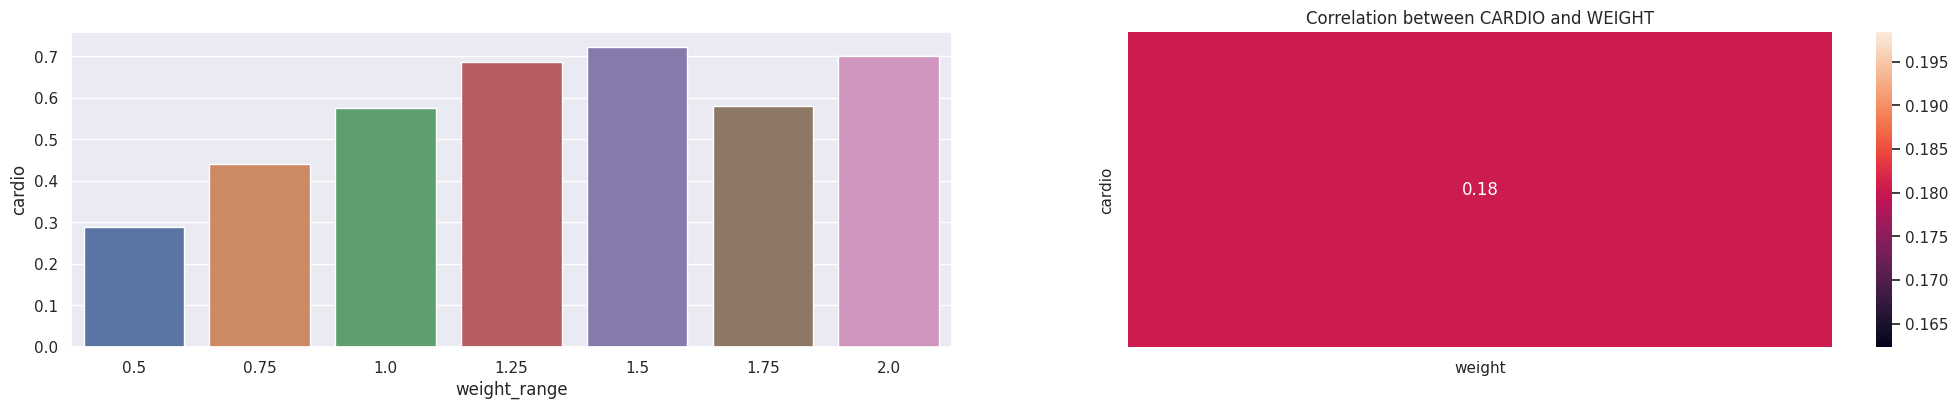

In [242]:
aux = df2[['weight_range', 'cardio']].groupby('weight_range').mean().reset_index()
grid = GridSpec(2,2)

plt.subplot(grid[1,0])
sns.barplot(x='weight_range', y='cardio', data=aux);
                 
plt.subplot(grid[1,1])
plt.title('Correlation between CARDIO and WEIGHT')
pointb = pointbiserialr(df2['weight'], df2['cardio']).correlation
sns.heatmap(pd.DataFrame({'weight':pointb}, index=['cardio']), annot=True);

### 5.3 - Multivariate Analysis

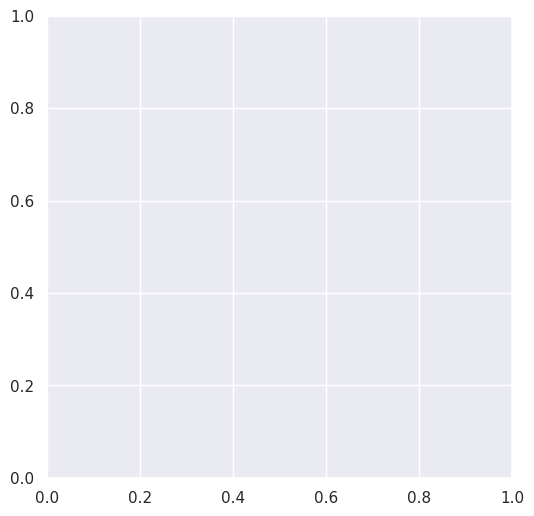

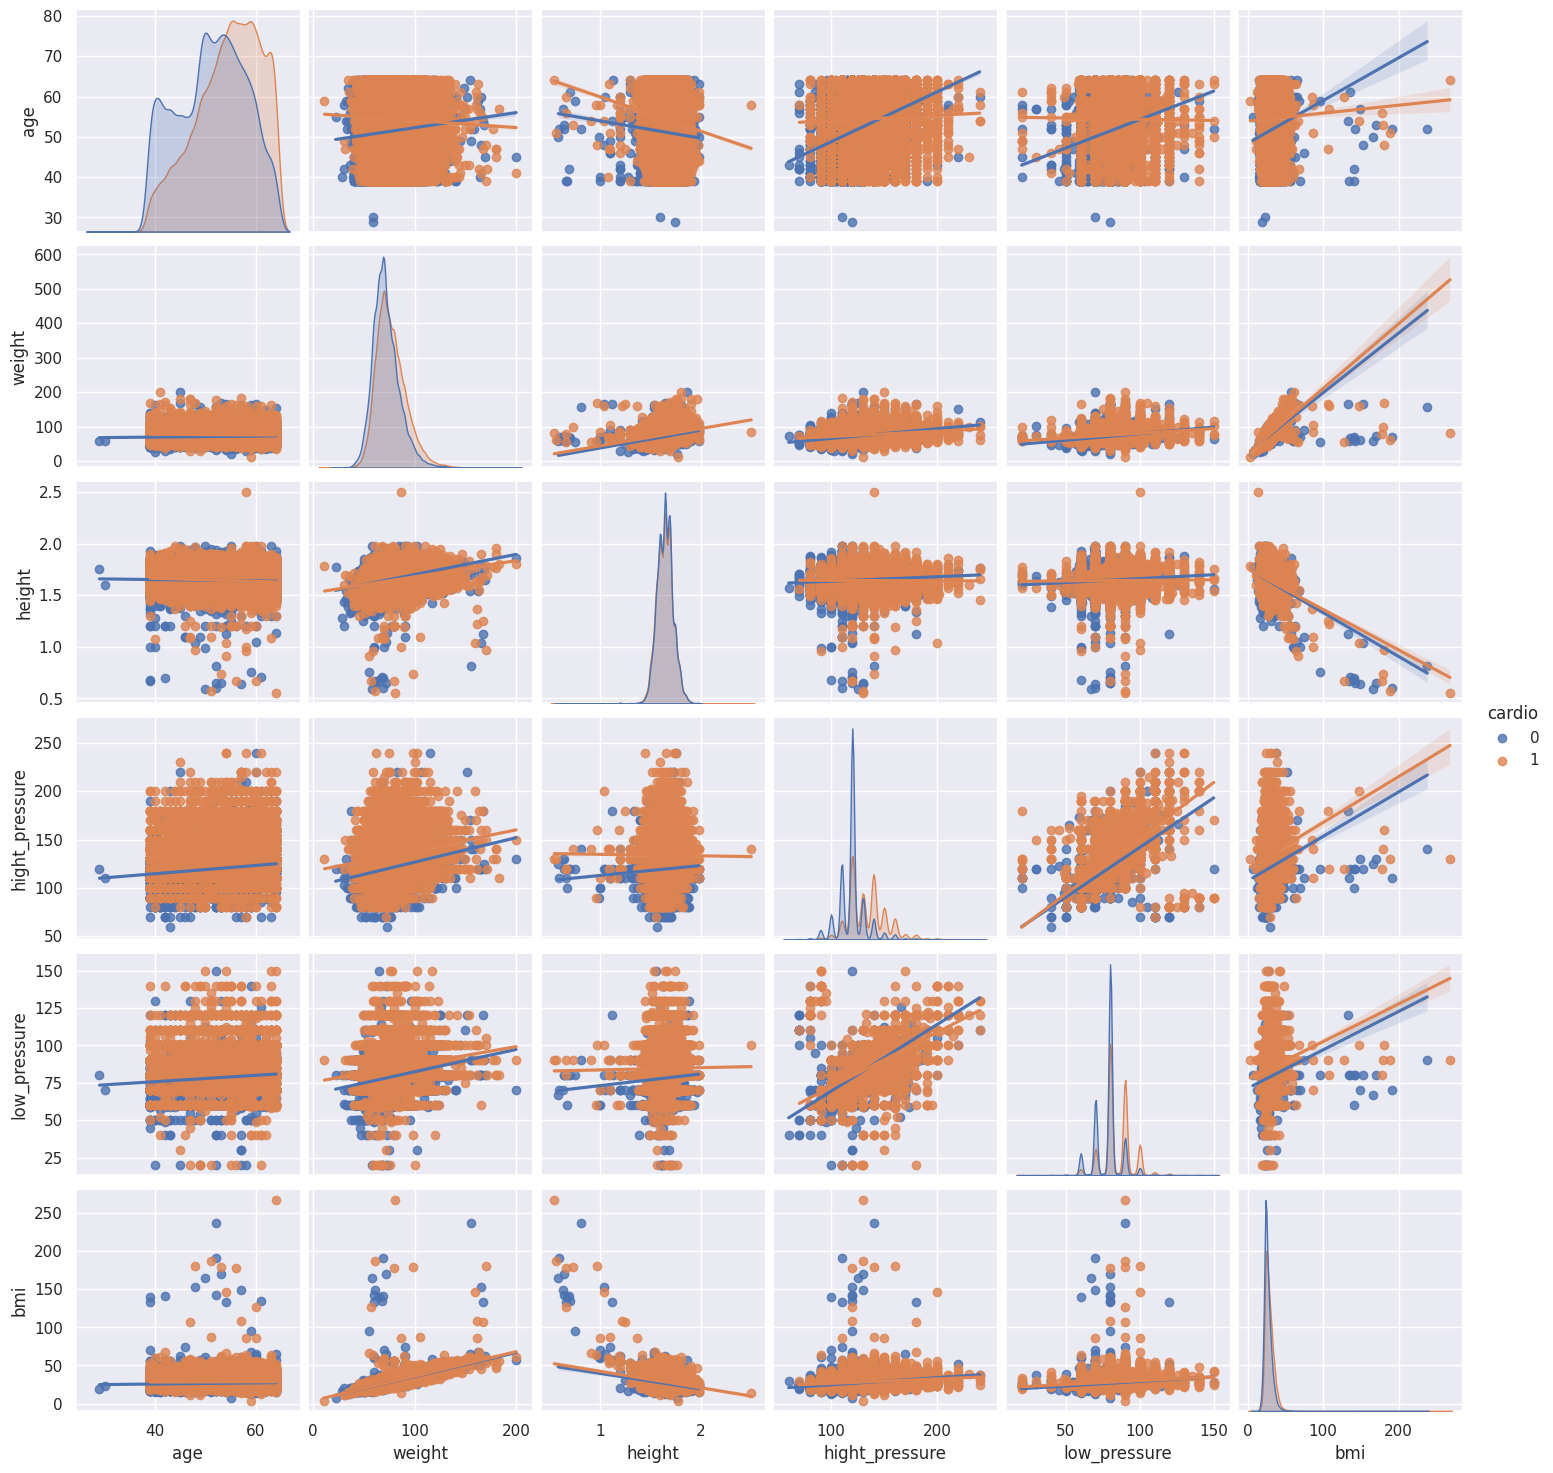

In [243]:
#pair grid
fig, ax=plt.subplots(figsize=(6,6))
vars=['age','weight','height','hight_pressure','low_pressure','bmi']
p=pairplot(df2,vars=vars,hue='cardio',kind='reg');

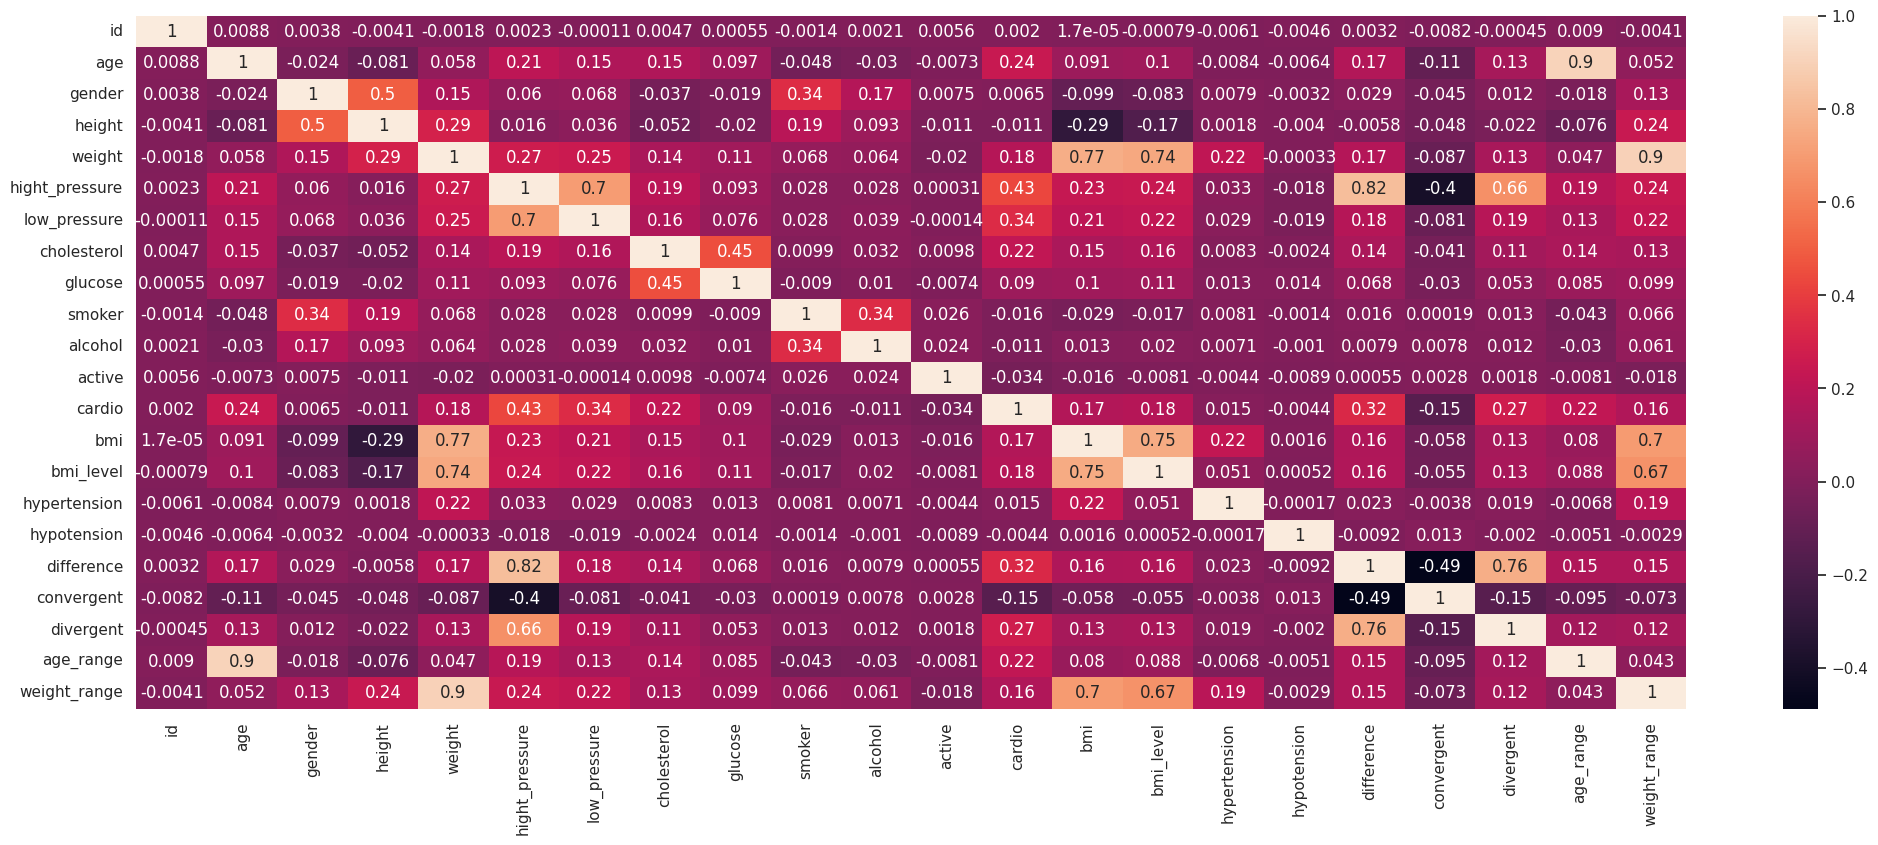

In [244]:
sns.heatmap(df2.corr(), annot=True);

## 6.0 - Data Preparation

In [245]:
df3=df2.copy()


### 6.1 - Normalization



In [246]:
# age
ss=StandardScaler()
df3['age'] = ss.fit_transform(df3[['age']].values)
#pickle.dump(mms, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\age_scaling.pkl', 'wb'))

### 6.2 - Rescaling Robust Scaler

In [247]:
rs = RobustScaler() #outiliers

# height         
df3['height'] = rs.fit_transform(df3[['height']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\height_scaling.pkl', 'wb'))

# weight
df3['weight'] = rs.fit_transform(df3[['weight']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\weight_scaling.pkl', 'wb'))

# difference     
df3['difference'] = rs.fit_transform(df3[['difference']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\difference_scaling.pkl', 'wb'))

# bmi            
df3['bmi'] = rs.fit_transform(df3[['bmi']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\bmi_scaling.pkl', 'wb'))


### 6.3 - Rescaling MinMaxScaler

In [248]:
mms = MinMaxScaler()
# low_pressure   
df3['low_pressure'] = mms.fit_transform(df3[['low_pressure']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\low_pressure_scaling.pkl', 'wb'))

#hight_pressure
df3['hight_pressure'] = mms.fit_transform(df3[['hight_pressure']].values)
pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\hight_pressure_scaling.pkl', 'wb'))

pickle.dump(mms, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\age_scaling.pkl', 'wb'))

### 6.4 - Encoding

In [249]:
 # Nominal variables
 # One hot encoder
 df3=pd.get_dummies(df3,prefix=['gender'],columns=['gender'])

# # Ordinal variables
# oe=OrdinalEncoder()
# df3['cholesterol']=oe.fit_transform(df3[['cholesterol']])
# df3['glucose']=oe.fit_transform(df3[['glucose']])
# df3['bmi_level']=oe.fit_transform(df3[['bmi_level']])
# df3['age_range']=oe.fit_transform(df3[['age_range']])
# df3['weight_range']=oe.fit_transform(df3[['weight_range']])


In [250]:
df3.head()

,id,age,height,weight,hight_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio,bmi,bmi_level,hypertension,hypotension,difference,convergent,divergent,age_range,weight_range,gender_1,gender_2
21043,30058,0.470515,0.909091,0.470588,0.388889,0.538462,1,3,0,0,1,1,-0.033718,2,0,0,0.0,0,0,2,1.00,0,1
49074,70050,-0.268301,-0.454545,1.294118,0.611111,0.538462,1,1,0,0,1,1,1.664108,3,0,0,4.0,0,1,2,1.00,1,0
6789,9679,1.061568,0.454545,0.470588,0.333333,0.461538,1,1,0,0,1,1,0.216111,2,0,0,0.0,0,0,3,1.00,1,0
25187,35961,0.027225,1.181818,0.117647,0.333333,0.461538,1,1,0,0,0,0,-0.477040,1,0,0,0.0,0,0,2,0.75,0,1
52373,74702,0.766041,-0.545455,-0.941176,0.388889,0.384615,1,3,0,0,1,0,-0.670053,1,0,0,2.0,0,1,2,0.75,0,1


In [ ]:
# ## The features that it's binary yet, it's not necessary transform
# ## If has the relevant outlier it's should use to RobustScaler else MinMaxScaler

# mms = MinMaxScaler()
# rs = RobustScaler()

# # age
# df3['age'] = mms.fit_transform(df3[['age']].values)
# pickle.dump(mms, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\age_scaling.pkl', 'wb'))

# # height         
# df3['height'] = rs.fit_transform(df3[['height']].values)
# pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\height_scaling.pkl', 'wb'))

# # weight
# df3['weight'] = rs.fit_transform(df3[['weight']].values)
# pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\weight_scaling.pkl', 'wb'))

# # low_pressure   
# df3['low_pressure'] = rs.fit_transform(df3[['low_pressure']].values)
# pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\low_pressure_scaling.pkl', 'wb'))

# #hight_pressure
# df3['hight_pressure'] = rs.fit_transform(df3[['hight_pressure']].values)
# pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\hight_pressure_scaling.pkl', 'wb'))

# # difference     
# df3['difference'] = rs.fit_transform(df3[['difference']].values)
# pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\difference_scaling.pkl', 'wb'))

# # bmi            
# df3['bmi'] = rs.fit_transform(df3[['bmi']].values)
# pickle.dump(rs, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\parameters\bmi_scaling.pkl', 'wb'))

## 7.0 - Feature Selection

In [251]:
## Spliting after rescaling

X = df3.drop(['cardio','id'], axis=1).copy()
y = df3['cardio'].copy()
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

### 7.1 - PCA

In [252]:
X.shape

(51593, 21)

In [253]:
pca= PCA(random_state=42)
X_pca=pca.fit_transform(StandardScaler().fit_transform(X))
pca.explained_variance_ratio_
pca.components_[0]

array([ 0.1525838 ,  0.0282931 ,  0.38934279,  0.35960423,  0.25199691,
        0.15532135,  0.10775921,  0.03314801,  0.0365064 , -0.00717083,
        0.35290787,  0.34863268,  0.09099434, -0.00576956,  0.29739847,
       -0.1578187 ,  0.25169768,  0.14251167,  0.36795927, -0.05693265,
        0.05693265])

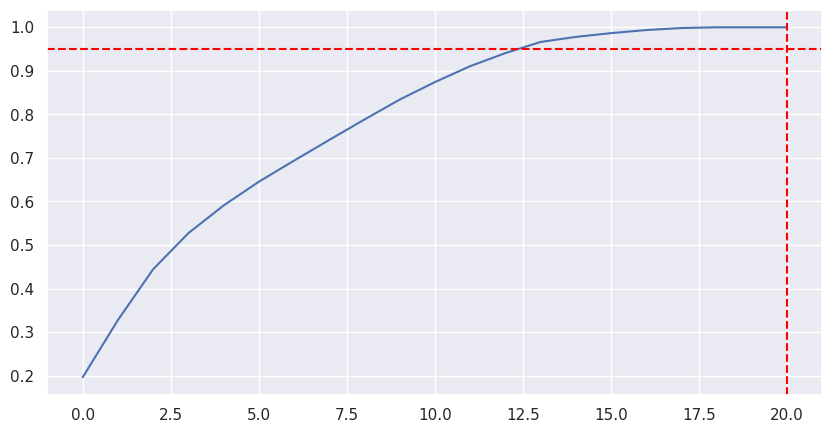

In [254]:
plt.figure(figsize=(10,5) )
plt.plot( np.cumsum( pca.explained_variance_ratio_ ) )
plt.axvline( 20, color='red', linestyle='--')
plt.axhline( 0.95, color='red', linestyle='--');

In [255]:
# change data to new space
k = np.argmax( np.cumsum( pca.explained_variance_ratio_ ) > 0.95 )
k

13

### 7.2 - RFE

In [256]:
# Create linear regression object
mdl = ExtraTreesClassifier(n_estimators=100)

# Create RFE object 
rfe = RFE(mdl, n_features_to_select=k)

# Fit RFE
rfe.fit(X, y)

# Print selected features
#print("Selected features: {}".format(X.columns[rfe.support_]))
select_features_rfe=list(X.columns[rfe.support_])
select_features_rfe

['age',
 'height',
 'weight',
 'hight_pressure',
 'low_pressure',
 'cholesterol',
 'glucose',
 'bmi',
 'bmi_level',
 'difference',
 'divergent',
 'age_range',
 'gender_2']

### 7.3 - Decision Tree

In [257]:
df1.dtypes

id                  int64
age                 int64
gender              int64
height            float64
weight            float64
hight_pressure      int64
low_pressure        int64
cholesterol         int64
glucose             int64
smoker              int64
alcohol             int64
active              int64
cardio              int64
bmi               float64
bmi_level           int64
hypertension        int64
hypotension         int64
difference          int64
convergent          int64
divergent           int64
age_range           int64
weight_range      float64
dtype: object

In [258]:
# Create ExtraTreesClassifier object
clf = ExtraTreesClassifier(n_estimators=100)

# Fit ExtraTreesClassifier
clf.fit(X, y)

# Print feature importances
print("Feature importances: {}".format(clf.feature_importances_))

# Select top 2 features
top_indices = clf.feature_importances_.argsort()[::-1][:9]
top_features = X.columns[top_indices]
#print("Selected features: {}".format(top_features))
select_features_dt=list(top_features)
select_features_dt

Feature importances: [1.24702677e-01 1.35885502e-01 1.31896307e-01 9.77583772e-02
 6.84736927e-02 4.38148670e-02 2.07070612e-02 9.74211392e-03
 8.17568056e-03 1.52128087e-02 1.51351669e-01 2.39536230e-02
 3.74082080e-04 1.22731616e-06 4.29165981e-02 1.03684731e-02
 5.31407277e-02 2.90756686e-02 1.90188454e-02 6.70451227e-03
 6.72548560e-03]


['bmi',
 'height',
 'weight',
 'age',
 'hight_pressure',
 'low_pressure',
 'divergent',
 'cholesterol',
 'difference']

### 7.4 - Boruta

In [259]:
!pip install boruta
from boruta import BorutaPy

x_boruta = x_train.values
y_boruta = y_train.ravel()
clf = ExtraTreesClassifier(n_estimators=100)

# Defining Boruta
boruta = BorutaPy(clf, n_estimators='auto', verbose=0, random_state=42).fit(x_boruta, y_boruta)

cols_selected = boruta.support_.tolist()
cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


['age', 'weight', 'hight_pressure', 'low_pressure', 'bmi', 'divergent']

### 7.5 Features selected

In [260]:
x_train = x_train[select_features_rfe].copy()
x_valid=x_valid[select_features_rfe].copy()

## 8.0 - Machine learning

### 8.1 - Baseline

The baseline is the "status quo", between **55%** and **65%** of **PRECISION** Score

### 8.2 - Random Forest

In [261]:
mdl = RandomForestClassifier(n_estimators=150, verbose=1,random_state=42).fit(x_train, y_train)
mdl_name = 'RandomForestClassifier'
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_rf = metrics_score(y_valid, y_hat, mdl_name)
df3_score_rf['accuracy_cv'] = mean(n_scores)
df3_score_rf['accuracy_cv_std'] = std(n_scores)
df3_score_rf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:   11.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.1s finished


,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,RandomForestClassifier,0.709782,0.707214,0.700905,0.704045,0.699654,0.00698


### 8.3 - GBDT

In [262]:
mdl = GradientBoostingClassifier().fit(x_train, y_train)
mdl_name ='GradientBoostingClassifier'
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_gbdt = metrics_score(y_valid, y_hat, mdl_name)
df3_score_gbdt['accuracy_cv'] = mean(n_scores)
df3_score_gbdt['accuracy_cv_std'] = std(n_scores)
df3_score_gbdt

,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,GradientBoostingClassifier,0.73976,0.756602,0.695264,0.724638,0.731866,0.006617


### 8.4 - Logistic Regression

In [263]:
mdl = LogisticRegression(random_state=42).fit(x_train, y_train)
mdl_name = 'LogisticRegression'
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_lr = metrics_score(y_valid, y_hat, mdl_name)
df3_score_lr['accuracy_cv'] = mean(n_scores)
df3_score_lr['accuracy_cv_std'] = std(n_scores)
df3_score_lr

,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,LogisticRegression,0.731231,0.759868,0.664174,0.708806,0.723946,0.007155


### 8.5 - XGBClassifier

In [264]:
mdl = XGBClassifier().fit(x_train, y_train)
mdl_name = 'XGBClassifier'

y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_xgbc = metrics_score(y_valid, y_hat, mdl_name)
df3_score_xgbc['accuracy_cv'] = mean(n_scores)
df3_score_xgbc['accuracy_cv_std'] = std(n_scores)
df3_score_xgbc

,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,XGBClassifier,0.735948,0.753804,0.688836,0.719857,0.724879,0.005969


### 8.6 - KNClassifier

In [265]:
mdl = KNeighborsClassifier().fit(x_train, y_train)
mdl_name = 'KNeighborsClassifier'
yhat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_knc = metrics_score(y_valid, y_hat, mdl_name)
df3_score_knc['accuracy_cv'] = mean(n_scores)
df3_score_knc['accuracy_cv_std'] = std(n_scores)
df3_score_knc

,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,KNeighborsClassifier,0.735948,0.753804,0.688836,0.719857,0.662061,0.008005


### 8.7 - LGBMClassifier

In [266]:
mdl = LGBMClassifier().fit(x_train, y_train)
mdl_name = 'LGBMClassifier'
y_hat = mdl.predict(x_valid)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

df3_score_lgbmc = metrics_score(y_valid, y_hat, mdl_name)
df3_score_lgbmc['accuracy_cv'] = mean(n_scores)
df3_score_lgbmc['accuracy_cv_std'] = std(n_scores)
df3_score_lgbmc

,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,LGBMClassifier,0.739437,0.761053,0.686475,0.721843,0.730952,0.005895


## 9.0 - Metrics

### 9.1 - Validation

In [267]:
df3_all_scores_sbs = pd.concat([df3_score_rf, df3_score_gbdt, df3_score_lr, df3_score_xgbc, df3_score_knc, df3_score_lgbmc], axis=0).reset_index(drop=True)
df3_all_scores_sbs.style.highlight_max(subset = ["accuracy",'precision','recall','F1_score','accuracy_cv','accuracy_cv_std'])

,mdl_name,accuracy,precision,recall,F1_score,accuracy_cv,accuracy_cv_std
0,RandomForestClassifier,0.709782,0.707214,0.700905,0.704045,0.699654,0.006980
1,GradientBoostingClassifier,0.739760,0.756602,0.695264,0.724638,0.731866,0.006617
2,LogisticRegression,0.731231,0.759868,0.664174,0.708806,0.723946,0.007155
3,XGBClassifier,0.735948,0.753804,0.688836,0.719857,0.724879,0.005969
4,KNeighborsClassifier,0.735948,0.753804,0.688836,0.719857,0.662061,0.008005
5,LGBMClassifier,0.739437,0.761053,0.686475,0.721843,0.730952,0.005895


## 10.0 - Hyperparameters

**Gradient Boosting it's better**

In [268]:
parameters = {'learning_rate':[0.01, 0.08], 
    'n_estimators':[100, 150],
    'subsample':[0.08, 0.1, 0.2, 0.6, 0.7, 0.8, 0.9, 1.0], 
    'min_samples_split':[0.3, 0.6, 0.8, 2, 3, 4],
    'min_samples_leaf':[1, 2, 3, 4], 
    'max_depth':[3, 5, 10, 15, 20, 25]}

In [269]:
# #RepeatedStratifiedKFold
# MAX_EVALS = 20
# df3_hyper = pd.DataFrame(columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])

# for i in range(MAX_EVALS):
#     print(f'evals: {i}')
    
#     hp = {k:sp(v, 1)[0] for k, v in parameters.items()}
#     print(f'Hyperparameters: {hp}')
#     mdl = GradientBoostingClassifier(
#         learning_rate=hp['learning_rate'], n_estimators=hp['n_estimators'],
#         subsample=hp['subsample'], min_samples_split=hp['min_samples_split'],
#         min_samples_leaf=hp['min_samples_leaf'], max_depth=hp['max_depth'],
#         loss='deviance', random_state=42
#         ).fit(x_train, y_train)
#     print('trained...')
    
#     cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
#     n_scores = cross_val_score(mdl, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
#     print('crossvalidation finished')
    
#     df3_cv = pd.DataFrame([[mean(n_scores), std(n_scores), hp]], 
#                         columns=['Mean_accuracy', 'Std_accuracy', 'Parameters'])
    
#     print(df3_cv)
#     df3_hyper = pd.concat([df3_hyper, df3_cv], axis=0)
    
# df3_hyper

## 11.0 - Final Model

In [270]:
learning_rate= 0.08
n_estimators= 100
subsample= 0.8
min_samples_split= 2
min_samples_leaf= 3
max_depth= 3

In [271]:
final_model = GradientBoostingClassifier(
        learning_rate=learning_rate, n_estimators=n_estimators,
        subsample=subsample, min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,max_depth=max_depth,
        loss='deviance', random_state=42
        ).fit(x_train, y_train)

pickle.dump(final_model, open(r'C:\Users\Utente77\repos\cardio_catch_disease_PA001\model\model_trained.pkl', 'wb'))

## 12.0 - Business Performance

In [272]:
cost_status_quo = 1000                         ## cost of each diagnostic with operators and machines
percentual_status_quo = (0.55+0.65)/2
revenue_status_quo = int((percentual_status_quo - 0.50)/0.05) * 500
result_status_quo = revenue_status_quo - cost_status_quo

cost_future = 0
standard = 0.006706
percentual_future = (0.752+0.765)/2
revenue_future = int((percentual_future - 0.50)/0.05) * 500  
result_model_future = revenue_future - cost_future   

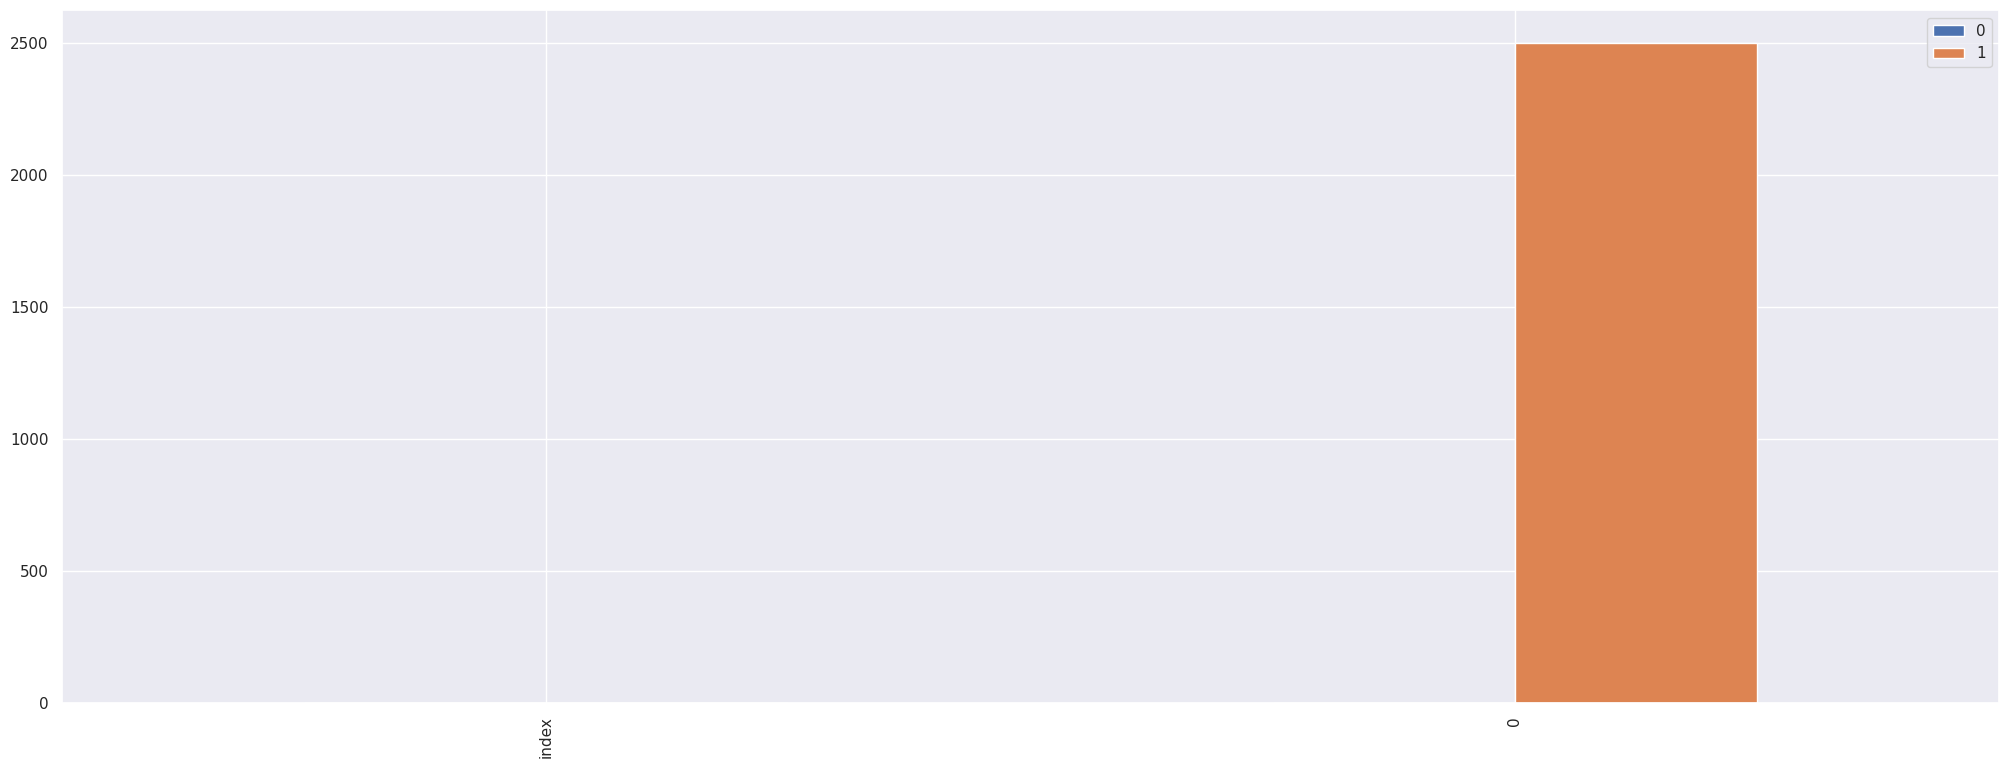

In [273]:
pd.concat([pd.Series(result_status_quo), pd.Series(result_model_future)]).reset_index().T.plot(kind='bar');

## 13.0 - Deploy

### 13.1 - Class

In [274]:
import pandas as pd
import numpy as np
import json
import pickle

# this file will be a handler "API"
class Cardio_Catch_Diseases(object):
    def __init__(self):
        self.home_path              = '/home/python/Documents/Projects/pa001_cardio_catch_diseases/'
        self.age_scaling            = pickle.load(open(self.home_path + 'parameters/age_scaling.pkl', 'rb'))
        self.bmi_scaling            = pickle.load(open(self.home_path + 'parameters/bmi_scaling.pkl', 'rb'))
        self.difference_scaling     = pickle.load(open(self.home_path + 'parameters/difference_scaling.pkl', 'rb'))
        self.height_scaling         = pickle.load(open(self.home_path + 'parameters/height_scaling.pkl', 'rb'))
        self.hight_pressure_scaling = pickle.load(open(self.home_path + 'parameters/hight_pressure_scaling.pkl', 'rb'))
        self.low_pressure_scaling   = pickle.load(open(self.home_path + 'parameters/low_pressure_scaling.pkl', 'rb'))
        self.weight_scaling         = pickle.load(open(self.home_path + 'parameters/weight_scaling.pkl', 'rb'))
        self.gender_encoder         = pickle.load(open(self.home_path + 'parameters/gender_encoder.pkl', 'rb'))


    
    def data_cleaning(self, df3):
        '''df3: is the input data from user on website'''


        # height - change centimeters to meters
        df3['height'] = (df3['height'] / 100)

        return df3

    def feature_engineering(self, df3):
        '''Get the dataframe from data cleaning and create a new features'''


        # feature engineering
        df3['difference'] = df3['hight_pressure'] - df3['low_pressure']
        df3['convergent'] = df3['difference'].apply(lambda x: 1 if x <= 30 else 0)
        df3['divergent'] = df3['difference'].apply(lambda x: 1 if x >= 60 else 0)
        df3['bmi'] = (df3['weight']/(df3['height'] * df3['height']))
        df3['bmi_level'] = df3['bmi'].apply(lambda x: 
                                                      'underweight' if x <= 18.5 else
                                                      'normal'      if x >  18.5 and x <= 24.9 else
                                                      'overweight'  if x >= 25.0 and x <= 29.9 else
                                                      'obesity')
        df3['hypertension'] = df3.apply(lambda x: 1 if x[4] >=140 and x[5] >= 90 else 0, axis=1)
        df3['hypotension'] = df3.apply(lambda x: 1 if x[4] <=90 and x[5] <= 60 else 0, axis=1)
        df3['age_range'] = df3['age'].apply(lambda x: 'age_0_50'    if x <= 50 
                                                           else 'age_51_59'   if x >= 51 and x <= 59 
                                                           else 'age_60_over' if x >= 60 
                                                           else x)

        df3['weight_range'] = df3['weight'].apply(
            lambda x:   0.50 if x <= 50  else
                        0.75 if x >= 51  and x <= 75 else
                        1.00 if x >= 76  and x <= 100 else
                        1.25 if x >= 101 and x <= 125 else
                        1.50 if x >= 126 and x <= 150 else
                        1.75 if x >= 151 and x <= 175 else 2.00)

        # Data Filtering rows, values or columns
        df3 = df3.drop('id', axis=1)

        return df3


    def data_rescaling(self, df3):
        '''
        Rescaling data
        Return: json file with x_test data to input the prediction
        '''


        # Transforming data to will be in correct data scaler to input at model
        df3['age']            = self.age_scaling.transform(df3[['age']].values)
        df3['height']         = self.height_scaling.transform(df3[['height']].values)
        df3['weight']         = self.weight_scaling.transform(df3[['weight']].values)
        df3['low_pressure']   = self.low_pressure_scaling.transform(df3[['low_pressure']].values)
        df3['hight_pressure'] = self.hight_pressure_scaling.transform(df3[['hight_pressure']].values)
        df3['difference']     = self.difference_scaling.transform(df3[['difference']].values)
        df3['bmi']            = self.bmi_scaling.transform(df3[['bmi']].values)
        df3['gender']         = self.gender_encoder.transform(df3[['gender']].values)
        df3['age_range']      = df3['age_range'].map(
            {'age_0_50':1, 'age_51_59':1, 'age_60_over':3})
        df3['bmi_level']      = df3['bmi_level'].map(
            {'underweight':1, 'normal':2, 'overweight':3, 'obesity':4})

        # Deleting target
        x_test = df3.drop('cardio', axis=1).copy()
        #data_json = json.dumps(x_test.to_dict(orient='records')) # converto to json

        return x_test

### 13.2 - Input Simulation

In [275]:
import pandas as pd

def input_simulation():
    # inputs from user
    
    age = input('age: ')
    gender = int(input('gender: '))
    height = int(input('height: '))
    weight = float(input('weight: '))
    ap_hi = int(input('hight_pressure: '))
    ap_lo = int(input('low_pressure: '))
    cholesterol = int(input('cholesterol (1,2 or 3): '))
    gluc = int(input('glucose (1,2 or 3): '))
    smoke = int(input('smoker: '))
    alco = int(input('alcohol: '))
    active = input('active: ')

    # replacing columns names
    new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
               'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

    # getting data and converting to dataframe
    df3_inputed = [[1, age, gender, height, weight, ap_hi, ap_lo, cholesterol, gluc, smoke, alco, active, 0,]]
    df3 = pd.DataFrame(df3_inputed, columns=new_col)

    # datatypes transformations
    df3['age'] = df3['age'].astype('int64')
    df3['gender'] = df3['gender'].astype('int64')
    df3['height'] = df3['height'].astype('int64')
    df3['weight'] = df3['weight'].astype('float64')
    df3['hight_pressure'] = df3['hight_pressure'].astype('int64') 
    df3['low_pressure'] = df3['low_pressure'].astype('int64') 
    df3['cholesterol'] = df3['cholesterol'].astype('int64')
    df3['glucose'] = df3['glucose'].astype('int64')
    df3['smoker'] = df3['smoker'].astype('int64') 
    df3['alcohol'] = df3['alcohol'].astype('int64')
    df3['active'] = df3['active'].astype('int64')
    df3['cardio'] = df3['cardio'].astype('int64')

    return json.dumps(df3.to_dict(orient='records'))

### 13.3 - API / Handler

In [276]:
import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, Response
from ccd.ccd import Cardio_Catch_Diseases
import json

# loading model trained from pickle file
with open('/home/python/Documents/Projects/pa001_cardio_catch_diseases/model/model_trained.pkl', 'rb') as file:
    model = pickle.load(file)

# initialized API
app = Flask(__name__)

@app.route('/ccd/predict', methods=['POST'])
def ccd_predict():
    '''
    ccd: Cardio Catch Diseases
    This function it will be create the API request, where the user will be input the user data that 
    will used to data_cleaning(), data_engineering(), data_scaler() 
    this functions will be return the dataframe 'x_est', that will be used to predict
    Return: Prediction "array"
    '''
    
    test_json = request.get_json()
        
    if test_json:
        if isinstance(test_json, dict): # Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate CCD class
        pipeline = Cardio_Catch_Diseases()
        # cleaning data
        test_raw_cleaned = pipeline.data_cleaning(test_raw)
        # creating derivates to new features
        test_raw_features = pipeline.feature_engineering(test_raw_cleaned)        
        
        # preparing data to model
        test_raw_selected = pipeline.data_rescaling(test_raw_features)
        
        y_hat = model.predict(test_raw_selected)
        test_raw['prediction'] = y_hat.copy()
        return test_raw.to_json(orient='records')
    
    else:
        return Response( "{}", status=200, mimetype='application/json')

    
if __name__=='__main__':
    app.run('0.0.0.0')

ModuleNotFoundError: ignored

### 13.4 - API Request Tester

In [ ]:
import requests

# Input data user
data = input_simulation()

# API request
url = "https://ccd-model.herokuapp.com/ccd/predict"
header = {'Content-type': 'application/json'}

response_ccd = requests.post(url, data=data, headers=header)
print(f'Status Code: {response_ccd.status_code}')

df3_response = pd.DataFrame(response_ccd.json(), columns=response_ccd.json()[0].keys())

# Loading json to Dataframe
df3_new = pd.DataFrame(json.loads(data))

# converting to back the original datatype
df3_new['age'] = df3_new['age'] * 365

# getting prediction
df3_new['cardio'] = df3_response['cardio'].copy()

# getting current time in seconds since the Epoch.
# convert to normal date use time.ctime(time.time())
df3_new['id'] = time.time()

# Insert into database
insert_database_values(df3_new)

df3_response

## 14.0 - Dashboard - PowerBI

In [ ]:
# Connecting sqlite database
import pandas as pd
from sqlalchemy import create_engine

new_col = ['id', 'age', 'gender', 'height', 'weight', 'hight_pressure', 'low_pressure',
           'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio']

engine = create_engine('sqlite:///Y:\\pa001_cardio_catch_diseases\\ccd.db', echo=False)
df3 = engine.execute('SELECT * FROM patients').fetchall()
df3 = pd.DataFrame(df3, columns=new_col)

# Data Preparation/transformation

